<a href="https://colab.research.google.com/github/msanchezj/improve-execution-algos/blob/master/Corporate_Credit_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)
rng = np.random.RandomState(16)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_dir = os.path.join('content', 'drive', 'My Drive', 'TFM Credit', 'Data')
file = os.path.join(data_dir, "corporate_rating.csv")

Mounted at /content/drive


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, cohen_kappa_score, mean_squared_error

class CreditRatingExperiment:

  def __init__(self, file):
    rating_map = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6, 'CC': 7, 'C': 8, 'D': 9}
    self.inv_rating_map = {v: k for k, v in rating_map.items()}
    self.__data__ = pd.read_csv("file:///" + file)\
                .drop(['Symbol', 'Rating Agency Name', 'Date', 'Name', 'Sector'], axis=1)\
                .replace({'Rating': rating_map})
    self.__data__ = self.__data__[(self.__data__.Rating != 9) & (self.__data__.Rating != 8)]
    self.__rng__ = np.random.RandomState(14)

  def get_data(self):
    return self.__data__

  def get_rng(self):
    return self.__rng__

  def get_inv_rating_map(self):
    return self.inv_rating_map

  def get_splitted_data(self, test_size):
    return train_test_split(self.get_data(), test_size=test_size, random_state=self.get_rng(), stratify=self.get_data().Rating)

  def get_train_test_data(self, test_size):
    train, test = self.get_splitted_data(test_size)
    x_train = train.loc[:, train.columns != 'Rating']
    y_train = train.Rating
    x_test = test.loc[:, test.columns != 'Rating']
    y_test = test.Rating

    return x_train, y_train, x_test, y_test

  def oversample(self, x_train, y_train):
    sm = SMOTE(random_state=14, k_neighbors=3)
    x_train_os, y_train_os = sm.fit_resample(x_train, y_train)

    return x_train_os, y_train_os

  def scale_data(self, x_train, x_test):
    scaler = RobustScaler(quantile_range=(0.05, 0.95))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test

  def select_features(self, x_train, x_test, y_train, method):
    if method == 'mutual_information':
      fs = SelectKBest(score_func=mutual_info_classif, k=int(x_train.shape[1]/3))
    if method == 'ANOVA':
      fs = SelectKBest(score_func=f_classif, k=int(x_train.shape[1]/3))

    feature_names = x_train.columns

    fs.fit(x_train, y_train)

    scores = fs.scores_

    sorted_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)
    sorted_feature_names = [x[0] for x in sorted_scores]
    sorted_scores = [x[1] for x in sorted_scores]

    plt.bar(sorted_feature_names, sorted_scores)
    if method == 'ANOVA':
      plt.ylabel('F-Score')
    if method == 'mutual_information':
      plt.ylabel('Información Mutua')
    plt.xticks(rotation=270)
    plt.title('Importancia de las variables')
    plt.show()

    X_train_fs = fs.transform(x_train)

    X_test_fs = fs.transform(x_test)
    print(fs.get_feature_names_out())

    return X_train_fs, X_test_fs

  def run(self, use_smote=True, use_scaling=True, feature_selection_method=None, test_size=0.2):
    train, test = self.get_splitted_data(test_size)
    x_train, y_train, x_test, y_test = self.get_train_test_data(test_size)

    if feature_selection_method is not None:
      x_train, x_test = self.select_features(x_train, x_test, y_train, feature_selection_method)

    if use_smote:
      x_train, y_train = self.oversample(x_train, y_train)

    if use_scaling:
      x_train, x_test = self.scale_data(x_train, x_test)

    self.run_baseline_model(train, test)
    self.run_lda(x_train, y_train, x_test, y_test)
    self.run_logistic_regression(x_train, y_train, x_test, y_test)
    self.run_svm(x_train, y_train, x_test, y_test)
    self.run_random_forest(x_train, y_train, x_test, y_test)
    self.run_neural_network(x_train, y_train, x_test, y_test)

  def run_baseline_model(self, train, test):
    x_train_bl = train.groupby('Rating').median()['debtRatio'].to_numpy().reshape(-1, 1)
    y_train_bl = train.groupby('Rating').median()['debtRatio'].index.to_numpy().reshape(-1, 1)
    x_test_bl = test['debtRatio'].to_numpy().reshape(-1, 1)
    y_test_bl = test.Rating.to_numpy().reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x_train_bl, y_train_bl)

    y_hat = lr.predict(x_test_bl)

    def predict_from_baseline(model, x_test):
      def piecewise_predictor(x):
        return np.piecewise(x, [x < 0.5,
                              ((x >= 0.5) & (x < 1.5)),
                              ((x >= 1.5) & (x < 32.5)),
                              ((x >= 2.5) & (x < 3.5)),
                              ((x >= 3.5) & (x < 4.5)),
                              ((x >= 4.5) & (x < 5.5)),
                              ((x >= 5.5) & (x < 6.5)),
                              x >= 6.5],
                              [0, 1, 2, 3, 4, 5, 6, 7])
      piecewise = np.vectorize(piecewise_predictor)
      pred = piecewise(model.predict(x_test))

      return pred

    y_hat = predict_from_baseline(lr, x_test_bl)
    c_matrix = confusion_matrix(y_test_bl, y_hat)
    mse = mean_squared_error(y_test_bl, y_hat)
    kappa_stat = cohen_kappa_score(y_test_bl, y_hat)

    y_test_bl = [self.get_inv_rating_map()[int(x)] for x in y_test_bl]
    y_hat = [self.get_inv_rating_map()[int(x)] for x in y_hat]

    ordered_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC']

    ConfusionMatrixDisplay.from_predictions(y_test_bl, y_hat, cmap='Blues', labels=ordered_labels)
    plt.title('Matriz de Confusión para el modelo baseline')
    plt.show()
    print('Reporte de Clasificación para el modelo baseline:\n' + classification_report(y_test_bl, y_hat, zero_division=0, labels=ordered_labels))
    print(f'Raiz del Error cuadrático medio para el modelo baseline: {np.sqrt(mse)}')
    print(f'Estadístico Kappa para el modelo baseline: {kappa_stat}')
    print('\n\n\n')

  def run_lda(self, x_train, y_train, x_test, y_test):
    lda = LDA(solver='lsqr')
    lda.fit(x_train, y_train)

    y_hat = lda.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    kappa_stat = cohen_kappa_score(y_test, y_hat)

    y_test = [self.get_inv_rating_map()[int(x)] for x in y_test]
    y_hat = [self.get_inv_rating_map()[int(x)] for x in y_hat]

    ordered_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC']

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues', labels=ordered_labels)
    plt.title('Matriz de Confusión para el modelo Linear Discriminant Analysis')
    plt.show()
    print('Reporte de Clasificación para el modelo Linear Discriminant Analysis:\n' + classification_report(y_test, y_hat, zero_division=0, labels=ordered_labels))
    print(f'Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: {np.sqrt(mse)}')
    print(f'Estadístico Kappa para el modelo Linear Discriminant Analysis: {kappa_stat}')
    print('\n\n\n')

  def run_logistic_regression(self, x_train, y_train, x_test, y_test):
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    log_reg = LogisticRegression(penalty='l2',
                                 solver='lbfgs',
                                 class_weight='balanced',
                                 max_iter=100000,
                                 multi_class = 'multinomial',
                                 random_state=self.get_rng())

    grid = GridSearchCV(log_reg,
                        param_grid,
                        refit=True,
                        verbose=3,
                        scoring='balanced_accuracy')

    grid.fit(x_train, y_train)

    print('Mejores valor de regularización para la regresión logística')
    print(grid.best_params_)

    y_hat = grid.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    kappa_stat = cohen_kappa_score(y_test, y_hat)

    y_test = [self.get_inv_rating_map()[int(x)] for x in y_test]
    y_hat = [self.get_inv_rating_map()[int(x)] for x in y_hat]

    ordered_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC']

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues', labels=ordered_labels)
    plt.title('Matriz de Confusión para el modelo Regresión Logística')
    plt.show()
    print('Reporte de Clasificación para el modelo Regresión Logística:\n' + classification_report(y_test, y_hat, zero_division=0, labels=ordered_labels))
    print(f'Raiz del Error cuadrático medio para el modelo de Regresión Logística: {np.sqrt(mse)}')
    print(f'Estadístico Kappa para el modelo Regresión Logística: {kappa_stat}')
    print('\n\n\n')

  def run_svm(self, x_train, y_train, x_test, y_test):
    param_grid = {'C': [0.01, 0.1, 1, 10, 100],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}

    grid = GridSearchCV(SVC(),
                        param_grid,
                        refit=True,
                        verbose=3,
                        scoring='balanced_accuracy')

    grid.fit(x_train, y_train)

    print('Mejores hiperparámetros para el modelo SVM')
    print(grid.best_params_)

    y_hat = grid.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    kappa_stat = cohen_kappa_score(y_test, y_hat)

    y_test = [self.get_inv_rating_map()[int(x)] for x in y_test]
    y_hat = [self.get_inv_rating_map()[int(x)] for x in y_hat]

    ordered_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC']

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues', labels=ordered_labels)
    plt.title('Matriz de Confusión para el modelo de Maquinas de Vectores Soporte')
    plt.show()
    print('Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:\n' + classification_report(y_test, y_hat, zero_division=0, labels=ordered_labels))
    print(f'Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: {np.sqrt(mse)}')
    print(f'Estadístico Kappa para el modelo Maquinas de Vectores Soporte: {kappa_stat}')
    print('\n\n\n')

  def run_random_forest(self, x_train, y_train, x_test, y_test):
    param_grid = {'n_estimators': [200, 300, 500, 1000],
                  'max_depth': [8, 10, 12, 15]}

    grid = GridSearchCV(RandomForestClassifier(criterion='entropy',
                                               bootstrap=True),
                        param_grid,
                        refit=True,
                        verbose=3,
                        scoring='balanced_accuracy')


    # rfc = RandomForestClassifier(criterion='entropy',
    #                              n_estimators=300,
    #                              max_depth=10,
    #                              bootstrap=True,
    #                              random_state=self.get_rng())

    grid.fit(x_train, y_train)

    print('Mejores hiperparámetros para el modelo de Árboles Aleatorios')
    print(grid.best_params_)

    y_hat = grid.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    kappa_stat = cohen_kappa_score(y_test, y_hat)

    y_test = [self.get_inv_rating_map()[int(x)] for x in y_test]
    y_hat = [self.get_inv_rating_map()[int(x)] for x in y_hat]

    ordered_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC']

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues', labels=ordered_labels)
    plt.title('Matriz de Confusión para el modelo de Árboles Aleatorios')
    plt.show()
    print('Reporte de Clasificación para el modelo de Árboles Aleatorios:\n' + classification_report(y_test, y_hat, zero_division=0, labels=ordered_labels))
    print(f'Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: {np.sqrt(mse)}')
    print(f'Estadístico Kappa para el modelo Árboles Aleatorios: {kappa_stat}')
    print('\n\n\n')

  def run_neural_network(self, x_train, y_train, x_test, y_test, loss_func='categorical_crossentropy'):
    model = Sequential()
    model.add(Dense(8, activation='relu', input_dim=x_train.shape[1]))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    y_train_enc = to_categorical(y_train, num_classes=8)

    model.compile(loss=loss_func, optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train_enc, epochs=850, batch_size=32, verbose=0)

    y_hat = list(map(np.argmax, model.predict(x_test)))

    mse = mean_squared_error(y_test, y_hat)
    kappa_stat = cohen_kappa_score(y_test, y_hat)

    y_test = [self.get_inv_rating_map()[int(x)] for x in y_test]
    y_hat = [self.get_inv_rating_map()[int(x)] for x in y_hat]
    ordered_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC']

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues', labels=ordered_labels)
    plt.title('Matriz de Confusión para el modelo de Red Neuronal')
    plt.show()
    print('Reporte de Clasificación para el modelo de Red Neuronal:\n' + classification_report(y_test, y_hat, zero_division=0, labels=ordered_labels))
    print(f'Raiz del Error cuadrático medio para el modelo Red Neuronal: {np.sqrt(mse)}')
    print(f'Estadístico Kappa para el modelo Red Neuronal: {kappa_stat}')

#Resultados Finales

In [ ]:
experiment = CreditRatingExperiment(file)

## Sin escalado, selección de variables ni preprocesamiento

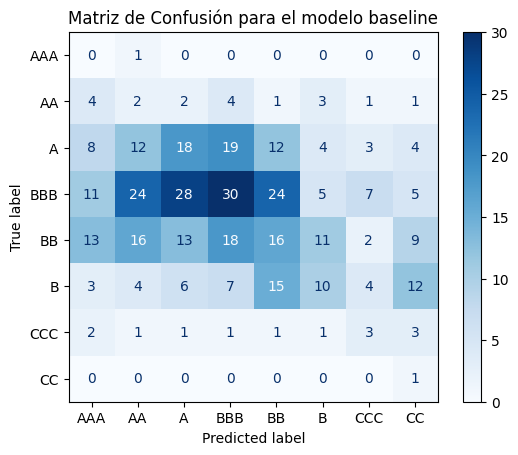

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.03      0.11      0.05        18
           A       0.26      0.23      0.24        80
         BBB       0.38      0.22      0.28       134
          BB       0.23      0.16      0.19        98
           B       0.29      0.16      0.21        61
         CCC       0.15      0.23      0.18        13
          CC       0.03      1.00      0.06         1

    accuracy                           0.20       406
   macro avg       0.17      0.26      0.15       406
weighted avg       0.28      0.20      0.23       406

Raiz del Error cuadrático medio para el modelo baseline: 2.097382840190394
Estadístico Kappa para el modelo baseline: 0.0447610386985956






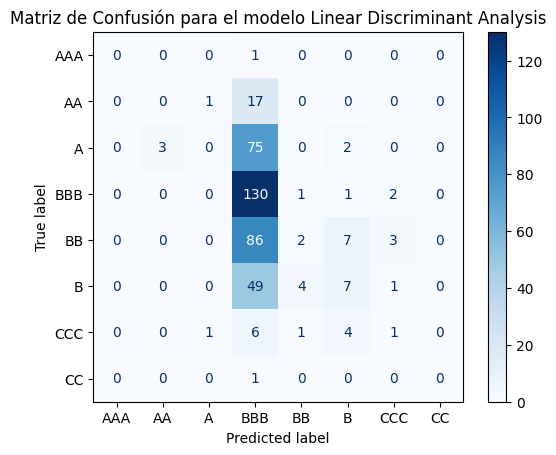

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.36      0.97      0.52       134
          BB       0.25      0.02      0.04        98
           B       0.33      0.11      0.17        61
         CCC       0.14      0.08      0.10        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.34       406
   macro avg       0.14      0.15      0.10       406
weighted avg       0.23      0.34      0.21       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 1.2126183858715383
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.04896262636936832




Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END ............................C=0.01;, score=0.423 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.406 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.164 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.162 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ............................C=0.01;, score=0.157 total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.314 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.422 total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.158 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.1;, score=0.163 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=0.1;, score=0.215 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.330 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.190 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.138 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.167 total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ...............................C=1;, score=0.222 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.367 total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.424 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.159 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.164 total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ..............................C=10;, score=0.215 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=100;, score=0.324 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=100;, score=0.404 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=100;, score=0.158 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=100;, score=0.175 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=100;, score=0.224 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mejores valor de regularización para la regresión logística
{'C': 10}


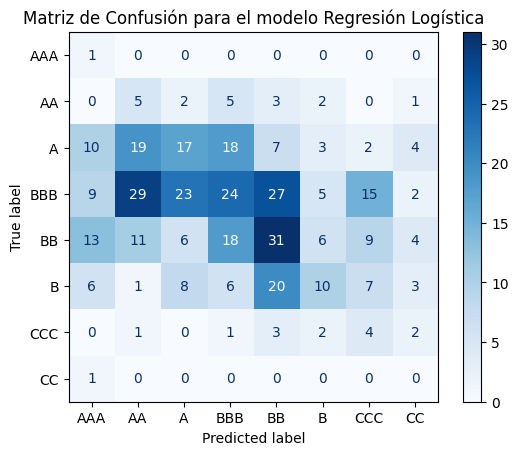

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.03      1.00      0.05         1
          AA       0.08      0.28      0.12        18
           A       0.30      0.21      0.25        80
         BBB       0.33      0.18      0.23       134
          BB       0.34      0.32      0.33        98
           B       0.36      0.16      0.22        61
         CCC       0.11      0.31      0.16        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.23       406
   macro avg       0.19      0.31      0.17       406
weighted avg       0.31      0.23      0.25       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.0110532005318653
Estadístico Kappa para el modelo Regresión Logística: 0.07858655507130108




Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.3s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.5s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.5s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.5s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.143 total time=   0.5s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.5s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.5s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.4s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.5s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.5s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.4s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.4s
[CV 3/5] END ....C=0.01, gam

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.363 total time=   0.3s
[CV 1/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.172 total time=   0.3s
[CV 2/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.152 total time=   0.3s
[CV 3/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.168 total time=   0.3s
[CV 4/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.147 total time=   0.3s
[CV 5/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.195 total time=   0.3s
Mejores hiperparámetros para el modelo SVM
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


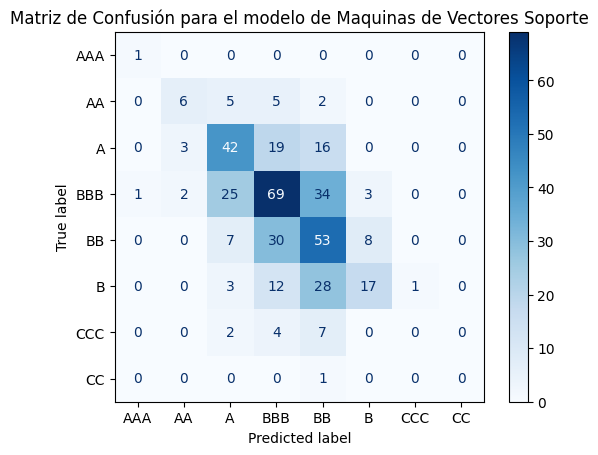

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.50      1.00      0.67         1
          AA       0.55      0.33      0.41        18
           A       0.50      0.53      0.51        80
         BBB       0.50      0.51      0.51       134
          BB       0.38      0.54      0.44        98
           B       0.61      0.28      0.38        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.46       406
   macro avg       0.38      0.40      0.37       406
weighted avg       0.47      0.46      0.45       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.1008281701058173
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.2847896178616738




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .....max_depth=8, n_estimators=200;, score=0.244 total time=   2.9s
[CV 2/5] END .....max_depth=8, n_estimators=200;, score=0.243 total time=   2.4s
[CV 3/5] END .....max_depth=8, n_estimators=200;, score=0.241 total time=   2.1s
[CV 4/5] END .....max_depth=8, n_estimators=200;, score=0.241 total time=   2.1s
[CV 5/5] END .....max_depth=8, n_estimators=200;, score=0.296 total time=   2.1s
[CV 1/5] END .....max_depth=8, n_estimators=300;, score=0.255 total time=   3.6s
[CV 2/5] END .....max_depth=8, n_estimators=300;, score=0.244 total time=   3.9s
[CV 3/5] END .....max_depth=8, n_estimators=300;, score=0.235 total time=   3.1s
[CV 4/5] END .....max_depth=8, n_estimators=300;, score=0.253 total time=   3.1s
[CV 5/5] END .....max_depth=8, n_estimators=300;, score=0.274 total time=   3.7s
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.244 total time=   5.8s
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.253 total time=   5.2s
[CV 3/5] END .....max_depth=

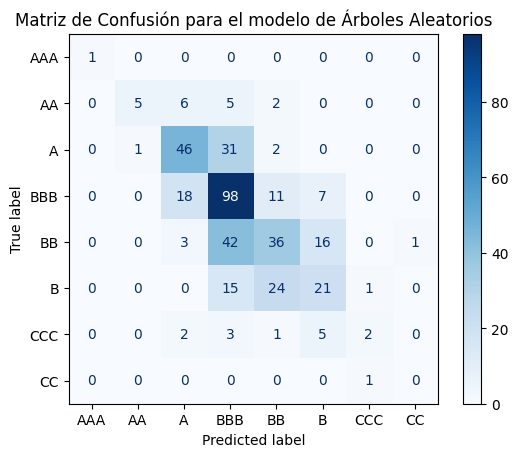

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       1.00      1.00      1.00         1
          AA       0.83      0.28      0.42        18
           A       0.61      0.57      0.59        80
         BBB       0.51      0.73      0.60       134
          BB       0.47      0.37      0.41        98
           B       0.43      0.34      0.38        61
         CCC       0.50      0.15      0.24        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.51       406
   macro avg       0.54      0.43      0.45       406
weighted avg       0.52      0.51      0.50       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 0.9597824055533901
Estadístico Kappa para el modelo Árboles Aleatorios: 0.3457023420947146




13/13 [==============================] - 0s 3ms/step


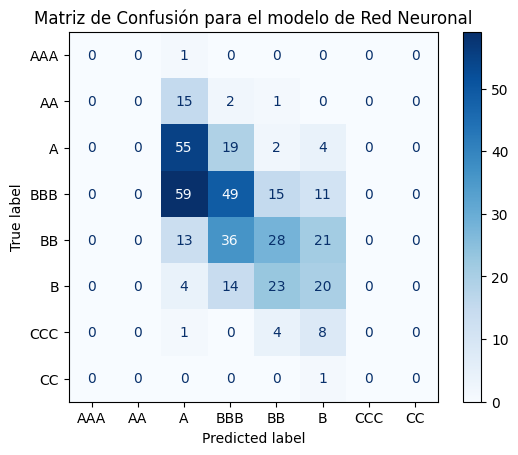

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.37      0.69      0.48        80
         BBB       0.41      0.37      0.39       134
          BB       0.38      0.29      0.33        98
           B       0.31      0.33      0.32        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.37       406
   macro avg       0.18      0.21      0.19       406
weighted avg       0.35      0.37      0.35       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.0929690209645364
Estadístico Kappa para el modelo Red Neuronal: 0.18023482277001845


In [ ]:
experiment.run(use_smote=False, use_scaling=False)

## Con escalado, sin smote y sin selección de variables

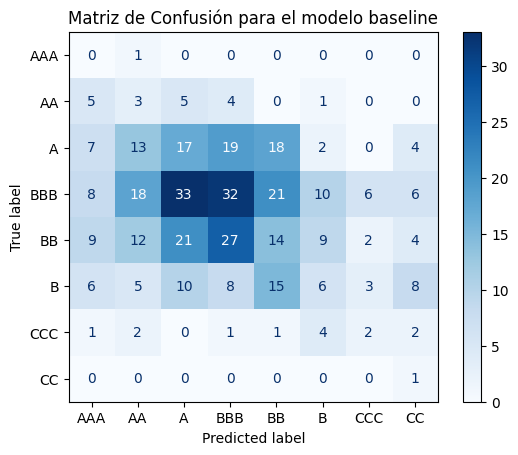

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.06      0.17      0.08        18
           A       0.20      0.21      0.20        80
         BBB       0.35      0.24      0.28       134
          BB       0.20      0.14      0.17        98
           B       0.19      0.10      0.13        61
         CCC       0.15      0.15      0.15        13
          CC       0.04      1.00      0.08         1

    accuracy                           0.18       406
   macro avg       0.15      0.25      0.14       406
weighted avg       0.24      0.18      0.20       406

Raiz del Error cuadrático medio para el modelo baseline: 1.987646577300944
Estadístico Kappa para el modelo baseline: 0.010747464040163024






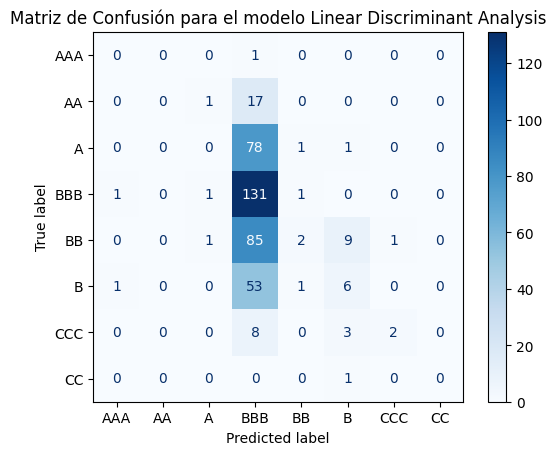

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.35      0.98      0.52       134
          BB       0.40      0.02      0.04        98
           B       0.30      0.10      0.15        61
         CCC       0.67      0.15      0.25        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.35       406
   macro avg       0.21      0.16      0.12       406
weighted avg       0.28      0.35      0.21       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 1.214647874129815
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.04672036008257796




Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.01;, score=0.207 total time=   2.2s
[CV 2/5] END ............................C=0.01;, score=0.382 total time=   9.6s
[CV 3/5] END ............................C=0.01;, score=0.355 total time=  13.9s
[CV 4/5] END ............................C=0.01;, score=0.115 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ............................C=0.01;, score=0.202 total time=   4.9s
[CV 1/5] END .............................C=0.1;, score=0.264 total time=   7.2s
[CV 2/5] END .............................C=0.1;, score=0.422 total time=   6.2s
[CV 3/5] END .............................C=0.1;, score=0.393 total time=   8.1s
[CV 4/5] END .............................C=0.1;, score=0.155 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=0.1;, score=0.161 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.259 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.408 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.268 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.162 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ...............................C=1;, score=0.265 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.257 total time=   9.7s
[CV 2/5] END ..............................C=10;, score=0.414 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.277 total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.160 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ..............................C=10;, score=0.255 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=100;, score=0.208 total time=   1.5s
[CV 2/5] END .............................C=100;, score=0.399 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=100;, score=0.265 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=100;, score=0.143 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=100;, score=0.170 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mejores valor de regularización para la regresión logística
{'C': 0.1}


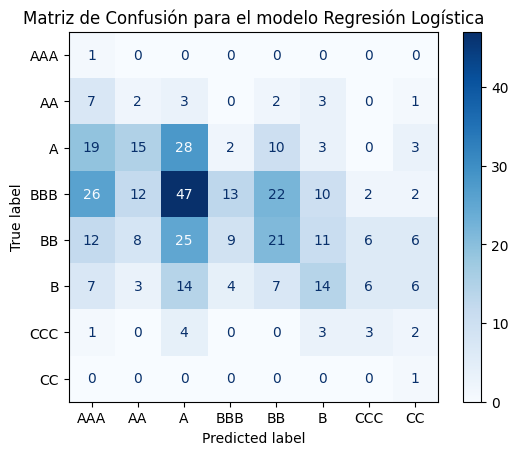

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.01      1.00      0.03         1
          AA       0.05      0.11      0.07        18
           A       0.23      0.35      0.28        80
         BBB       0.46      0.10      0.16       134
          BB       0.34      0.21      0.26        98
           B       0.32      0.23      0.27        61
         CCC       0.18      0.23      0.20        13
          CC       0.05      1.00      0.09         1

    accuracy                           0.20       406
   macro avg       0.21      0.40      0.17       406
weighted avg       0.34      0.20      0.22       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.080285126346038
Estadístico Kappa para el modelo Regresión Logística: 0.07394304034348098




Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END ....C=0.01, gam

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.327 total time=   0.3s
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.309 total time=   0.2s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.316 total time=   0.2s
[CV 3/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.307 total time=   0.2s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.163 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.258 total time=   0.2s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.154 total time=   0.2s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.164 total time=   0.2s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.148 total time=   0.2s
[CV 4/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.160 total time=   0.2s
[CV 5/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.165 total time=   0.2s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.136 total time=   0.2s
[CV 2/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.143 total time=   0.2s
[CV 3/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.138 total time=   0.2s
[CV 4/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.152 total time=   0.2s
[CV 5/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.152 total time=   0.2s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.128 total time=   0.2s
[CV 2/5] END ....C=10, gamma

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.356 total time=   0.5s
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.325 total time=   0.3s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.336 total time=   0.4s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.337 total time=   0.3s
[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.175 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.339 total time=   0.4s
[CV 1/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.282 total time=   0.3s
[CV 2/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.301 total time=   0.3s
[CV 3/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.168 total time=   0.3s
[CV 4/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.179 total time=   0.3s
[CV 5/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.244 total time=   0.3s
[CV 1/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.143 total time=   0.2s
[CV 2/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.155 total time=   0.3s
[CV 3/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.138 total time=   0.3s
[CV 4/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.156 total time=   0.3s
[CV 5/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.161 total time=   0.3s
[CV 1/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.140 total time=   0.3s
[CV 2/5] END ...C=100, gamma

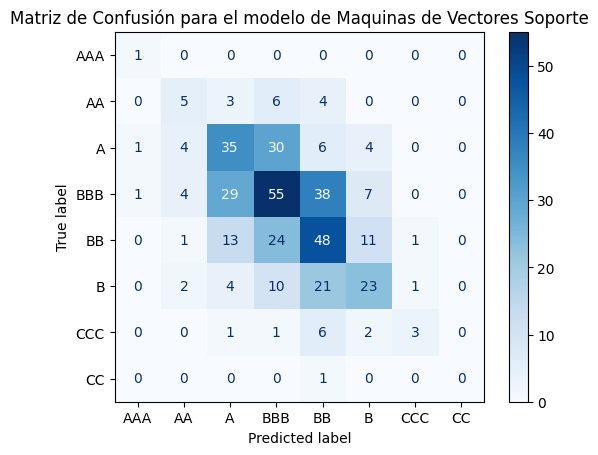

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.33      1.00      0.50         1
          AA       0.31      0.28      0.29        18
           A       0.41      0.44      0.42        80
         BBB       0.44      0.41      0.42       134
          BB       0.39      0.49      0.43        98
           B       0.49      0.38      0.43        61
         CCC       0.60      0.23      0.33        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.42       406
   macro avg       0.37      0.40      0.35       406
weighted avg       0.43      0.42      0.42       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.18591902796384
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.23820730340205276




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .....max_depth=8, n_estimators=200;, score=0.242 total time=   2.0s
[CV 2/5] END .....max_depth=8, n_estimators=200;, score=0.277 total time=   2.6s
[CV 3/5] END .....max_depth=8, n_estimators=200;, score=0.287 total time=   2.6s
[CV 4/5] END .....max_depth=8, n_estimators=200;, score=0.225 total time=   2.0s
[CV 5/5] END .....max_depth=8, n_estimators=200;, score=0.245 total time=   2.0s
[CV 1/5] END .....max_depth=8, n_estimators=300;, score=0.234 total time=   3.0s
[CV 2/5] END .....max_depth=8, n_estimators=300;, score=0.270 total time=   3.5s
[CV 3/5] END .....max_depth=8, n_estimators=300;, score=0.275 total time=   3.7s
[CV 4/5] END .....max_depth=8, n_estimators=300;, score=0.250 total time=   3.0s
[CV 5/5] END .....max_depth=8, n_estimators=300;, score=0.243 total time=   3.0s
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.240 total time=   6.2s
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.262 total time=   5.0s
[CV 3/5] END .....max_depth=

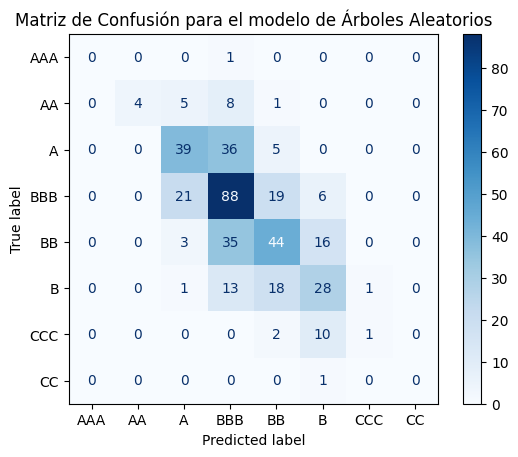

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       1.00      0.22      0.36        18
           A       0.57      0.49      0.52        80
         BBB       0.49      0.66      0.56       134
          BB       0.49      0.45      0.47        98
           B       0.46      0.46      0.46        61
         CCC       0.50      0.08      0.13        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.50       406
   macro avg       0.44      0.29      0.31       406
weighted avg       0.52      0.50      0.49       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 0.9151166175112985
Estadístico Kappa para el modelo Árboles Aleatorios: 0.33062903502256746




13/13 [==============================] - 0s 2ms/step


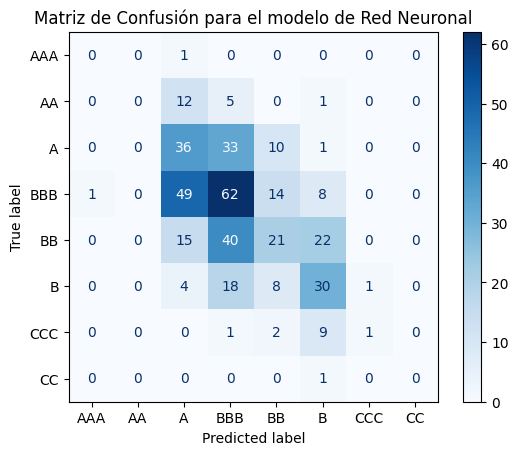

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.31      0.45      0.37        80
         BBB       0.39      0.46      0.42       134
          BB       0.38      0.21      0.27        98
           B       0.42      0.49      0.45        61
         CCC       0.50      0.08      0.13        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.37       406
   macro avg       0.25      0.21      0.21       406
weighted avg       0.36      0.37      0.35       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.117483097369443
Estadístico Kappa para el modelo Red Neuronal: 0.1642395927983853


In [ ]:
experiment.run(use_smote=False, use_scaling=True)

## Con Smote, escalado y sin selección de variables

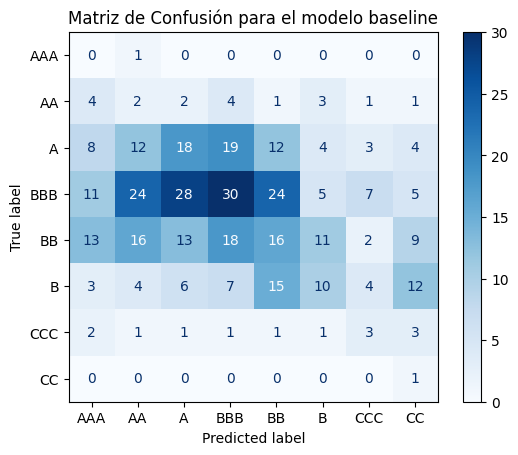

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.03      0.11      0.05        18
           A       0.26      0.23      0.24        80
         BBB       0.38      0.22      0.28       134
          BB       0.23      0.16      0.19        98
           B       0.29      0.16      0.21        61
         CCC       0.15      0.23      0.18        13
          CC       0.03      1.00      0.06         1

    accuracy                           0.20       406
   macro avg       0.17      0.26      0.15       406
weighted avg       0.28      0.20      0.23       406

Raiz del Error cuadrático medio para el modelo baseline: 2.097382840190394
Estadístico Kappa para el modelo baseline: 0.0447610386985956






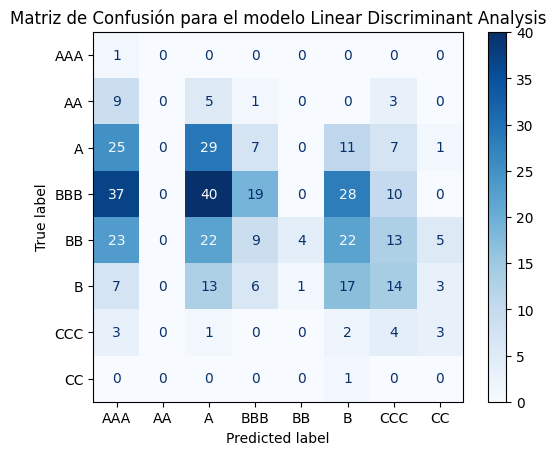

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.01      1.00      0.02         1
          AA       0.00      0.00      0.00        18
           A       0.26      0.36      0.31        80
         BBB       0.45      0.14      0.22       134
          BB       0.80      0.04      0.08        98
           B       0.21      0.28      0.24        61
         CCC       0.08      0.31      0.12        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.18       406
   macro avg       0.23      0.27      0.12       406
weighted avg       0.43      0.18      0.19       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 2.2585360793387554
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.06522327094183655




Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.01;, score=0.407 total time=  24.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.370 total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.329 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.171 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=0.01;, score=0.319 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.406 total time=  34.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.375 total time=  32.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.384 total time=  29.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.1;, score=0.269 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=0.1;, score=0.375 total time=  27.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.420 total time=  37.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.384 total time=  27.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.356 total time=  17.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.367 total time=  11.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...............................C=1;, score=0.369 total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.388 total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.382 total time=  21.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.173 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.244 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..............................C=10;, score=0.342 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=100;, score=0.376 total time=  16.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=100;, score=0.368 total time=  14.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=100;, score=0.173 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=100;, score=0.281 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=100;, score=0.176 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mejores valor de regularización para la regresión logística
{'C': 1}


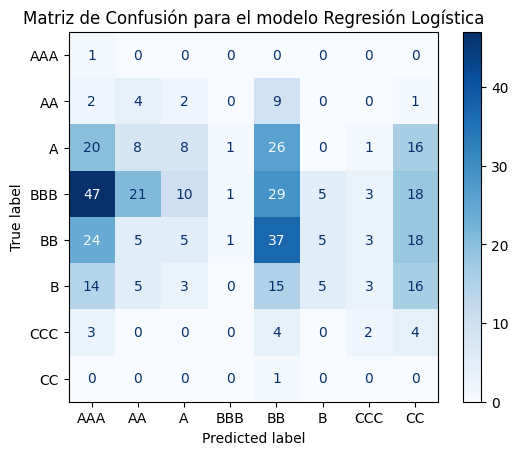

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.01      1.00      0.02         1
          AA       0.09      0.22      0.13        18
           A       0.29      0.10      0.15        80
         BBB       0.33      0.01      0.01       134
          BB       0.31      0.38      0.34        98
           B       0.33      0.08      0.13        61
         CCC       0.17      0.15      0.16        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.14       406
   macro avg       0.19      0.24      0.12       406
weighted avg       0.30      0.14      0.15       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.6799750017215116
Estadístico Kappa para el modelo Regresión Logística: 0.04732750308481737




Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.

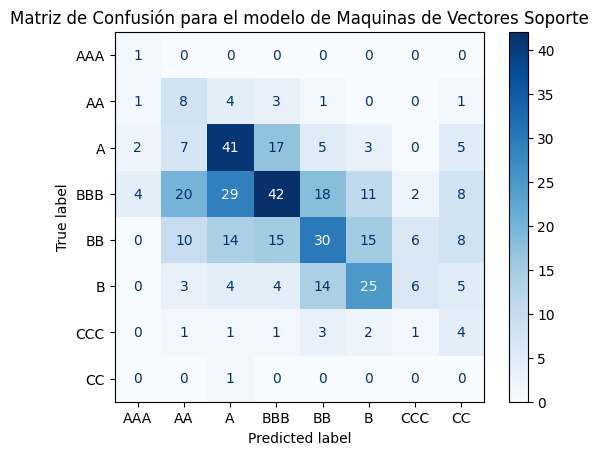

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.12      1.00      0.22         1
          AA       0.16      0.44      0.24        18
           A       0.44      0.51      0.47        80
         BBB       0.51      0.31      0.39       134
          BB       0.42      0.31      0.36        98
           B       0.45      0.41      0.43        61
         CCC       0.07      0.08      0.07        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.36       406
   macro avg       0.27      0.38      0.27       406
weighted avg       0.43      0.36      0.38       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.6638728636539335
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.22315667690117014




Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .....max_depth=8

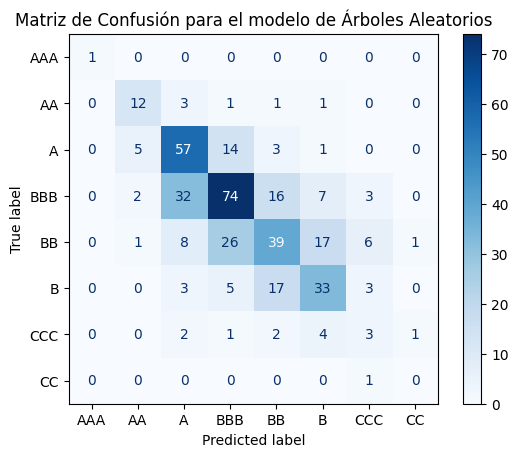

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       1.00      1.00      1.00         1
          AA       0.60      0.67      0.63        18
           A       0.54      0.71      0.62        80
         BBB       0.61      0.55      0.58       134
          BB       0.50      0.40      0.44        98
           B       0.52      0.54      0.53        61
         CCC       0.19      0.23      0.21        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.54       406
   macro avg       0.50      0.51      0.50       406
weighted avg       0.54      0.54      0.54       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 1.0195140347219718
Estadístico Kappa para el modelo Árboles Aleatorios: 0.4076183639711619




13/13 [==============================] - 0s 2ms/step


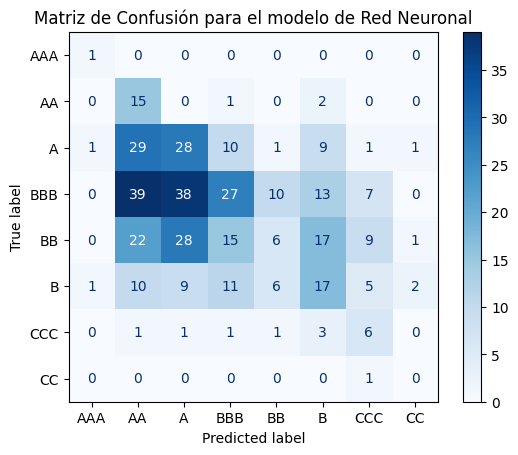

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.33      1.00      0.50         1
          AA       0.13      0.83      0.22        18
           A       0.27      0.35      0.30        80
         BBB       0.42      0.20      0.27       134
          BB       0.25      0.06      0.10        98
           B       0.28      0.28      0.28        61
         CCC       0.21      0.46      0.29        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.25       406
   macro avg       0.24      0.40      0.25       406
weighted avg       0.31      0.25      0.24       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.7880280576588752
Estadístico Kappa para el modelo Red Neuronal: 0.10789093859731014


In [ ]:
experiment.run(use_smote=True, use_scaling=True)

## Sin Escalado, sin Smote y usando la técnica ANOVA

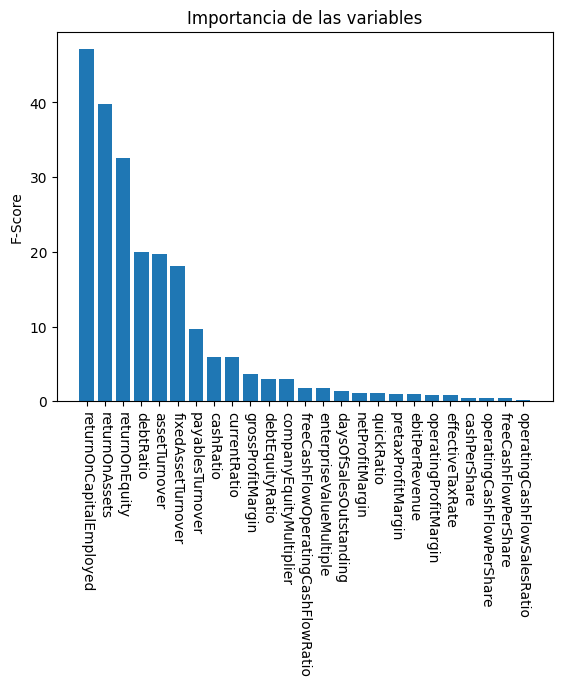

['cashRatio' 'returnOnAssets' 'returnOnCapitalEmployed' 'returnOnEquity'
 'assetTurnover' 'fixedAssetTurnover' 'debtRatio' 'payablesTurnover']


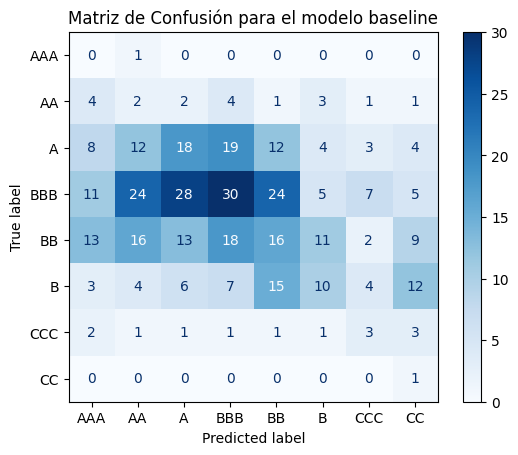

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.03      0.11      0.05        18
           A       0.26      0.23      0.24        80
         BBB       0.38      0.22      0.28       134
          BB       0.23      0.16      0.19        98
           B       0.29      0.16      0.21        61
         CCC       0.15      0.23      0.18        13
          CC       0.03      1.00      0.06         1

    accuracy                           0.20       406
   macro avg       0.17      0.26      0.15       406
weighted avg       0.28      0.20      0.23       406

Raiz del Error cuadrático medio para el modelo baseline: 2.097382840190394
Estadístico Kappa para el modelo baseline: 0.0447610386985956






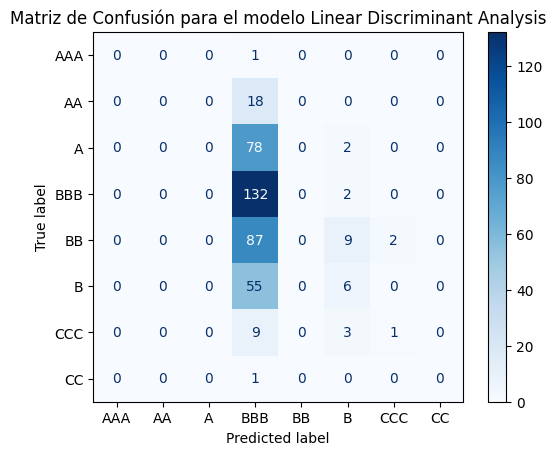

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.35      0.99      0.51       134
          BB       0.00      0.00      0.00        98
           B       0.27      0.10      0.14        61
         CCC       0.33      0.08      0.12        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.34       406
   macro avg       0.12      0.15      0.10       406
weighted avg       0.17      0.34      0.19       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 1.224744871391589
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.03557797528491746




Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........................

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Ple

[CV 2/5] END ............................C=0.01;, score=0.328 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.156 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.093 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ............................C=0.01;, score=0.165 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.252 total time=   0.5s
[CV 2/5] END .............................C=0.1;, score=0.264 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.152 total time=   0.2s
[CV 4/5] END .............................C=0.1;, score=0.174 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=0.1;, score=0.141 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.257 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.294 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.148 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.134 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ...............................C=1;, score=0.137 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.245 total time=   0.8s
[CV 2/5] END ..............................C=10;, score=0.300 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.152 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.103 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ..............................C=10;, score=0.169 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=100;, score=0.270 total time=   1.2s
[CV 2/5] END .............................C=100;, score=0.298 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=100;, score=0.146 total time=   0.8s
[CV 4/5] END .............................C=100;, score=0.188 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=100;, score=0.126 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mejores valor de regularización para la regresión logística
{'C': 100}


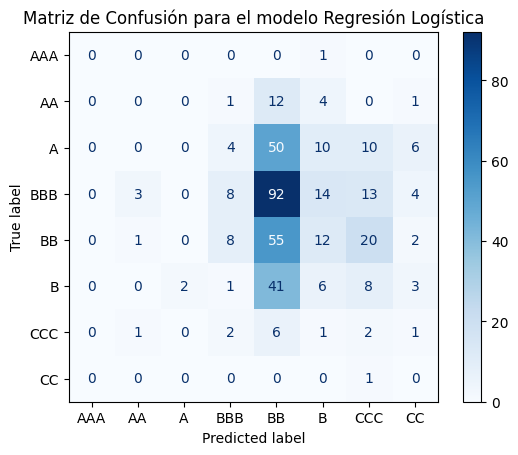

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.33      0.06      0.10       134
          BB       0.21      0.56      0.31        98
           B       0.12      0.10      0.11        61
         CCC       0.04      0.15      0.06        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.17       406
   macro avg       0.09      0.11      0.07       406
weighted avg       0.18      0.17      0.13       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 1.8976262070478678
Estadístico Kappa para el modelo Regresión Logística: -0.025445772232065345




Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 3/5] END ....C=0.01, gam

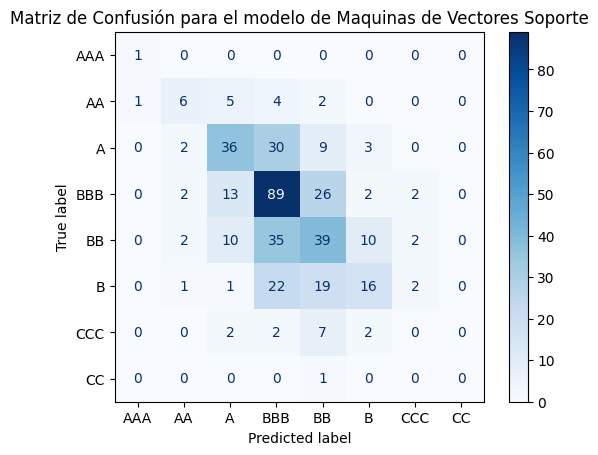

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.50      1.00      0.67         1
          AA       0.46      0.33      0.39        18
           A       0.54      0.45      0.49        80
         BBB       0.49      0.66      0.56       134
          BB       0.38      0.40      0.39        98
           B       0.48      0.26      0.34        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.46       406
   macro avg       0.36      0.39      0.35       406
weighted avg       0.45      0.46      0.45       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.1554113421020793
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.2751595783707108




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .....max_depth=8, n_estimators=200;, score=0.225 total time=   1.2s
[CV 2/5] END .....max_depth=8, n_estimators=200;, score=0.220 total time=   1.7s
[CV 3/5] END .....max_depth=8, n_estimators=200;, score=0.251 total time=   1.6s
[CV 4/5] END .....max_depth=8, n_estimators=200;, score=0.226 total time=   1.1s
[CV 5/5] END .....max_depth=8, n_estimators=200;, score=0.287 total time=   1.1s
[CV 1/5] END .....max_depth=8, n_estimators=300;, score=0.234 total time=   1.6s
[CV 2/5] END .....max_depth=8, n_estimators=300;, score=0.227 total time=   1.6s
[CV 3/5] END .....max_depth=8, n_estimators=300;, score=0.226 total time=   1.6s
[CV 4/5] END .....max_depth=8, n_estimators=300;, score=0.238 total time=   1.6s
[CV 5/5] END .....max_depth=8, n_estimators=300;, score=0.255 total time=   1.8s
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.226 total time=   3.7s
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.209 total time=   2.6s
[CV 3/5] END .....max_depth=

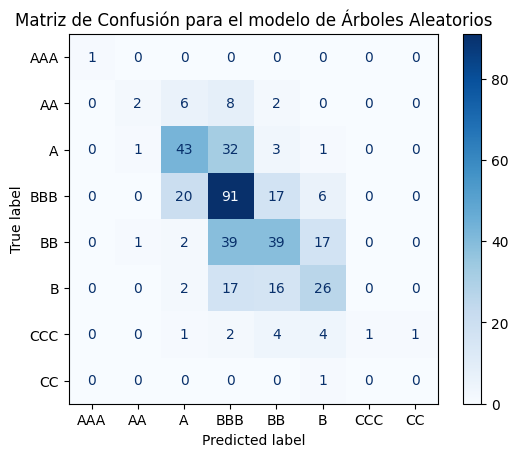

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       1.00      1.00      1.00         1
          AA       0.50      0.11      0.18        18
           A       0.58      0.54      0.56        80
         BBB       0.48      0.68      0.56       134
          BB       0.48      0.40      0.44        98
           B       0.47      0.43      0.45        61
         CCC       1.00      0.08      0.14        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.50       406
   macro avg       0.56      0.40      0.42       406
weighted avg       0.52      0.50      0.48       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 0.9987677136415694
Estadístico Kappa para el modelo Árboles Aleatorios: 0.3256034694378529




13/13 [==============================] - 0s 2ms/step


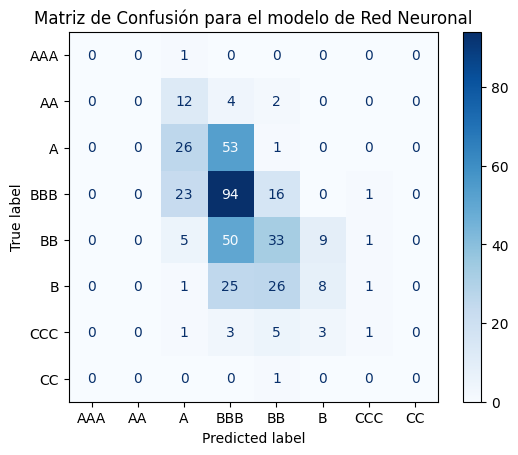

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.38      0.33      0.35        80
         BBB       0.41      0.70      0.52       134
          BB       0.39      0.34      0.36        98
           B       0.40      0.13      0.20        61
         CCC       0.25      0.08      0.12        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.40       406
   macro avg       0.23      0.20      0.19       406
weighted avg       0.37      0.40      0.36       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.0516231882424718
Estadístico Kappa para el modelo Red Neuronal: 0.16840991890939017


In [ ]:
experiment.run(use_smote=False, use_scaling=False, feature_selection_method='ANOVA')

## Sin Smote, con Escalado y con la técnica ANOVA

['returnOnAssets' 'returnOnCapitalEmployed' 'returnOnEquity'
 'assetTurnover' 'fixedAssetTurnover' 'debtRatio'
 'enterpriseValueMultiple' 'payablesTurnover']


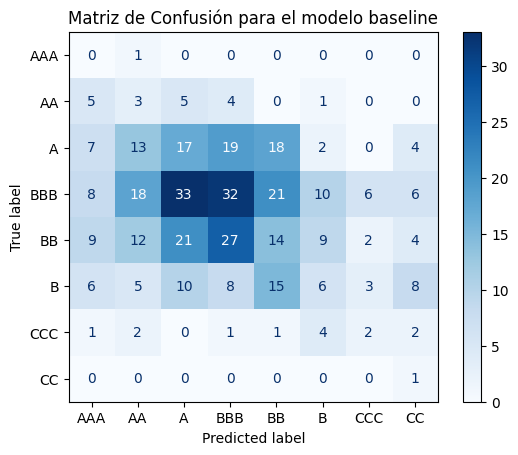

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.06      0.17      0.08        18
           A       0.20      0.21      0.20        80
         BBB       0.35      0.24      0.28       134
          BB       0.20      0.14      0.17        98
           B       0.19      0.10      0.13        61
         CCC       0.15      0.15      0.15        13
          CC       0.04      1.00      0.08         1

    accuracy                           0.18       406
   macro avg       0.15      0.25      0.14       406
weighted avg       0.24      0.18      0.20       406

Raiz del Error cuadrático medio para el modelo baseline: 1.987646577300944
Estadístico Kappa para el modelo baseline: 0.010747464040163024






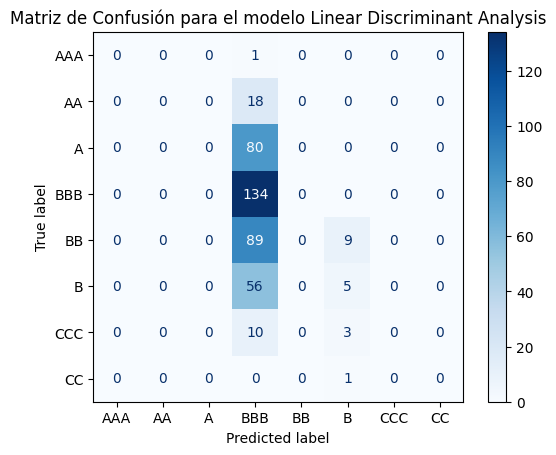

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.35      1.00      0.51       134
          BB       0.00      0.00      0.00        98
           B       0.28      0.08      0.13        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.34       406
   macro avg       0.08      0.14      0.08       406
weighted avg       0.16      0.34      0.19       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 1.1952286093343936
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.02992500850142288




Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END ............................C=0.01;, score=0.220 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.330 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.313 total time=   0.2s
[CV 4/5] END ............................C=0.01;, score=0.201 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pleas

[CV 5/5] END ............................C=0.01;, score=0.215 total time=   0.2s
[CV 1/5] END .............................C=0.1;, score=0.296 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.313 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.209 total time=   0.5s
[CV 4/5] END .............................C=0.1;, score=0.236 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pleas

[CV 5/5] END .............................C=0.1;, score=0.185 total time=   0.2s
[CV 1/5] END ...............................C=1;, score=0.295 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.289 total time=   0.1s
[CV 3/5] END ...............................C=1;, score=0.183 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr

[CV 4/5] END ...............................C=1;, score=0.141 total time=   0.1s
[CV 5/5] END ...............................C=1;, score=0.172 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.226 total time=   0.3s
[CV 2/5] END ..............................C=10;, score=0.294 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.204 total time=   0.5s
[CV 4/5] END ..............................C=10;, score=0.257 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ..............................C=10;, score=0.273 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=100;, score=0.207 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=100;, score=0.335 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=100;, score=0.183 total time=   0.3s
[CV 4/5] END .............................C=100;, score=0.138 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=100;, score=0.261 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mejores valor de regularización para la regresión logística
{'C': 0.01}


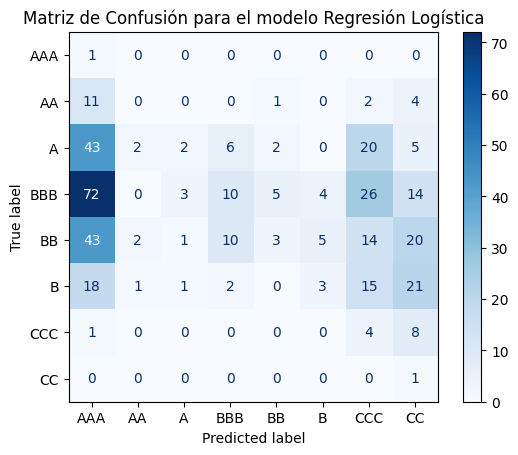

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.01      1.00      0.01         1
          AA       0.00      0.00      0.00        18
           A       0.29      0.03      0.05        80
         BBB       0.36      0.07      0.12       134
          BB       0.27      0.03      0.06        98
           B       0.25      0.05      0.08        61
         CCC       0.05      0.31      0.09        13
          CC       0.01      1.00      0.03         1

    accuracy                           0.06       406
   macro avg       0.15      0.31      0.05       406
weighted avg       0.28      0.06      0.08       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.9628238427474405
Estadístico Kappa para el modelo Regresión Logística: 0.01409328137614485




Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.143 total time=   0.1s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.1s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 3/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 4/5] END ....C=0.01, gam

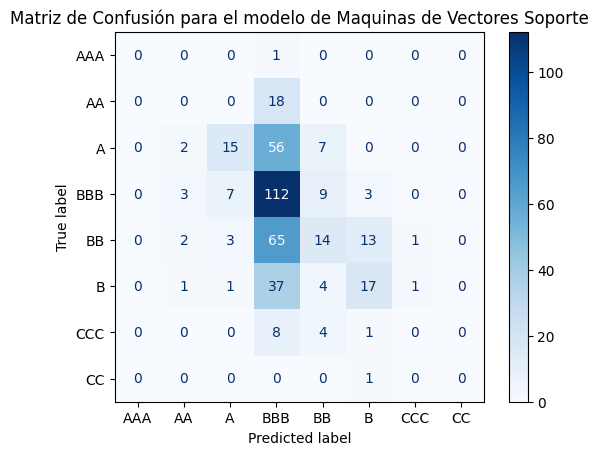

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.58      0.19      0.28        80
         BBB       0.38      0.84      0.52       134
          BB       0.37      0.14      0.21        98
           B       0.49      0.28      0.35        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.39       406
   macro avg       0.23      0.18      0.17       406
weighted avg       0.40      0.39      0.33       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.2054882705540315
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.13889625328190602




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .....max_depth=8, n_estimators=200;, score=0.235 total time=   1.6s
[CV 2/5] END .....max_depth=8, n_estimators=200;, score=0.217 total time=   1.5s
[CV 3/5] END .....max_depth=8, n_estimators=200;, score=0.213 total time=   1.0s
[CV 4/5] END .....max_depth=8, n_estimators=200;, score=0.199 total time=   1.0s
[CV 5/5] END .....max_depth=8, n_estimators=200;, score=0.235 total time=   1.0s
[CV 1/5] END .....max_depth=8, n_estimators=300;, score=0.221 total time=   1.5s
[CV 2/5] END .....max_depth=8, n_estimators=300;, score=0.204 total time=   1.5s
[CV 3/5] END .....max_depth=8, n_estimators=300;, score=0.202 total time=   1.5s
[CV 4/5] END .....max_depth=8, n_estimators=300;, score=0.199 total time=   1.5s
[CV 5/5] END .....max_depth=8, n_estimators=300;, score=0.223 total time=   1.7s
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.231 total time=   3.4s
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.205 total time=   2.5s
[CV 3/5] END .....max_depth=

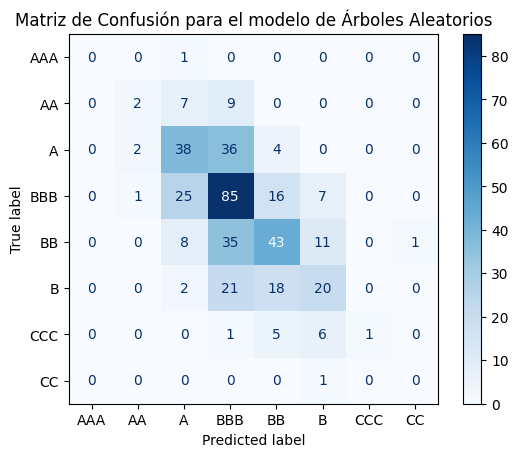

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.40      0.11      0.17        18
           A       0.47      0.47      0.47        80
         BBB       0.45      0.63      0.53       134
          BB       0.50      0.44      0.47        98
           B       0.44      0.33      0.38        61
         CCC       1.00      0.08      0.14        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.47       406
   macro avg       0.41      0.26      0.27       406
weighted avg       0.48      0.47      0.45       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 1.0170952554312156
Estadístico Kappa para el modelo Árboles Aleatorios: 0.2779767417083945




13/13 [==============================] - 0s 2ms/step


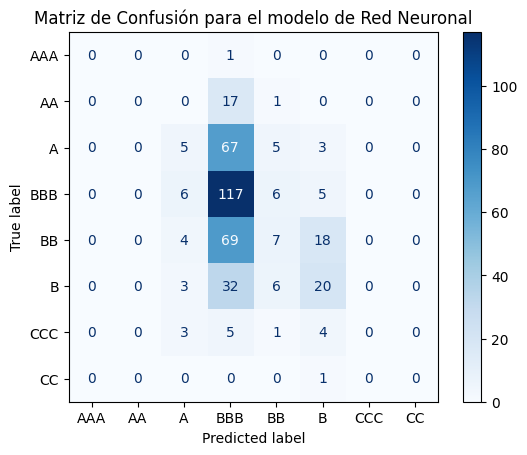

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.24      0.06      0.10        80
         BBB       0.38      0.87      0.53       134
          BB       0.27      0.07      0.11        98
           B       0.39      0.33      0.36        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.37       406
   macro avg       0.16      0.17      0.14       406
weighted avg       0.30      0.37      0.28       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.2166739770795063
Estadístico Kappa para el modelo Red Neuronal: 0.10224134222413417


In [ ]:
experiment.run(use_smote=False, use_scaling=True, feature_selection_method='ANOVA')

## Con Smote, con Escalado y con la técnica ANOVA

['returnOnAssets' 'returnOnCapitalEmployed' 'returnOnEquity'
 'assetTurnover' 'fixedAssetTurnover' 'debtRatio'
 'enterpriseValueMultiple' 'payablesTurnover']


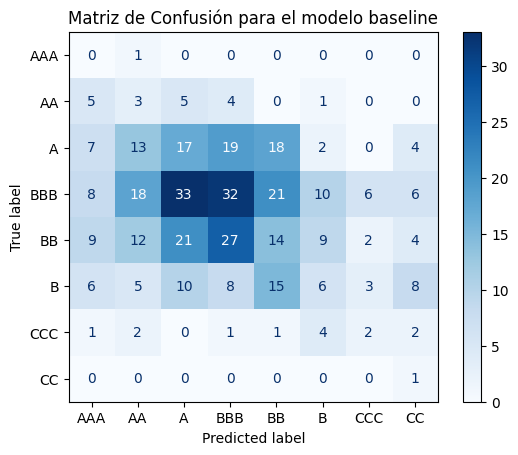

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.06      0.17      0.08        18
           A       0.20      0.21      0.20        80
         BBB       0.35      0.24      0.28       134
          BB       0.20      0.14      0.17        98
           B       0.19      0.10      0.13        61
         CCC       0.15      0.15      0.15        13
          CC       0.04      1.00      0.08         1

    accuracy                           0.18       406
   macro avg       0.15      0.25      0.14       406
weighted avg       0.24      0.18      0.20       406

Raiz del Error cuadrático medio para el modelo baseline: 1.987646577300944
Estadístico Kappa para el modelo baseline: 0.010747464040163024






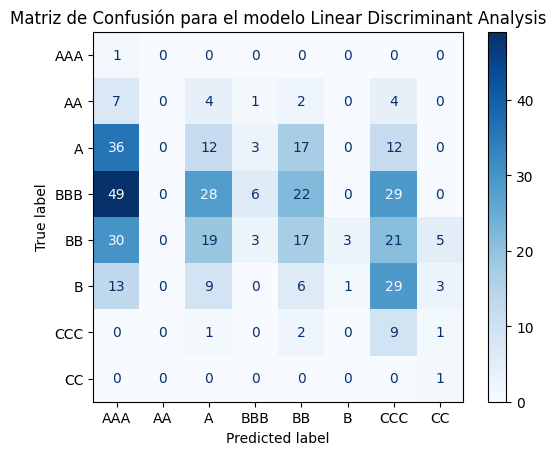

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.01      1.00      0.01         1
          AA       0.00      0.00      0.00        18
           A       0.16      0.15      0.16        80
         BBB       0.46      0.04      0.08       134
          BB       0.26      0.17      0.21        98
           B       0.25      0.02      0.03        61
         CCC       0.09      0.69      0.15        13
          CC       0.10      1.00      0.18         1

    accuracy                           0.12       406
   macro avg       0.17      0.38      0.10       406
weighted avg       0.29      0.12      0.12       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 2.4620268793576976
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.022074018410670693




Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.350 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.301 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.328 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=0.01;, score=0.364 total time=   2.4s
[CV 1/5] END .............................C=0.1;, score=0.237 total time=   0.1s
[CV 2/5] END .............................C=0.1;, score=0.204 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.367 total time=   3.5s
[CV 4/5] END .............................C=0.1;, score=0.196 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=0.1;, score=0.309 total time=   1.1s
[CV 1/5] END ...............................C=1;, score=0.237 total time=   0.1s
[CV 2/5] END ...............................C=1;, score=0.204 total time=   0.2s
[CV 3/5] END ...............................C=1;, score=0.201 total time=   0.2s
[CV 4/5] END ...............................C=1;, score=0.196 total time=   0.2s
[CV 5/5] END ...............................C=1;, score=0.320 total time=   1.1s
[CV 1/5] END ..............................C=10;, score=0.237 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.281 total time=   0.5s
[CV 3/5] END ..............................C=10;, score=0.201 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.291 total time=   0.7s
[CV 5/5] END ..............................C=10;, score=0.379 total time=   2.9s
[CV 1/5] END .............................C=100;, score=0.237 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=100;, score=0.361 total time=   3.1s
[CV 3/5] END .............................C=100;, score=0.323 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=100;, score=0.367 total time=   1.7s
[CV 5/5] END .............................C=100;, score=0.342 total time=   1.8s
Mejores valor de regularización para la regresión logística
{'C': 100}


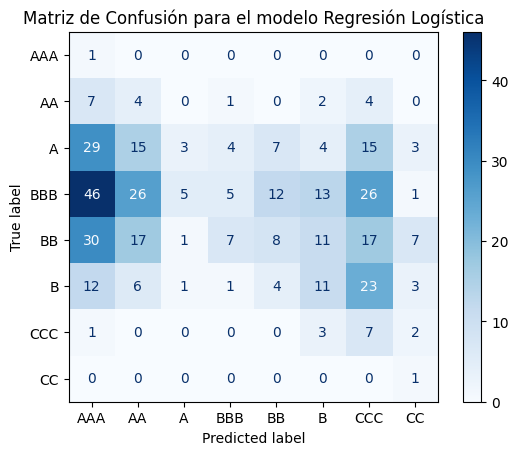

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.01      1.00      0.02         1
          AA       0.06      0.22      0.09        18
           A       0.30      0.04      0.07        80
         BBB       0.28      0.04      0.07       134
          BB       0.26      0.08      0.12        98
           B       0.25      0.18      0.21        61
         CCC       0.08      0.54      0.13        13
          CC       0.06      1.00      0.11         1

    accuracy                           0.10       406
   macro avg       0.16      0.39      0.10       406
weighted avg       0.26      0.10      0.10       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.6115506972553635
Estadístico Kappa para el modelo Regresión Logística: 0.030931465576272132




Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0

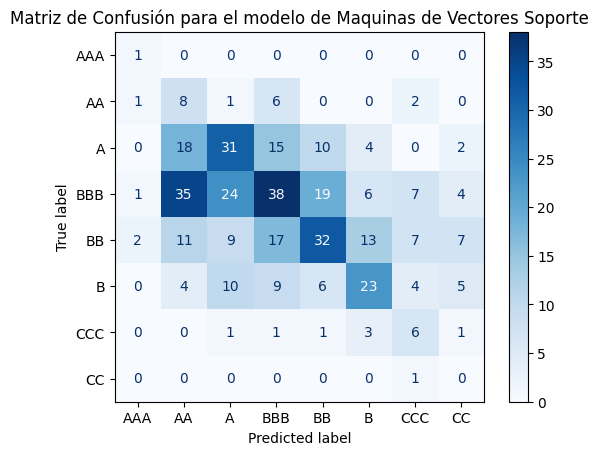

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.20      1.00      0.33         1
          AA       0.11      0.44      0.17        18
           A       0.41      0.39      0.40        80
         BBB       0.44      0.28      0.35       134
          BB       0.47      0.33      0.39        98
           B       0.47      0.38      0.42        61
         CCC       0.22      0.46      0.30        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.34       406
   macro avg       0.29      0.41      0.29       406
weighted avg       0.42      0.34      0.37       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.6609095970747993
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.2019641332194705




Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .....max_depth=8,

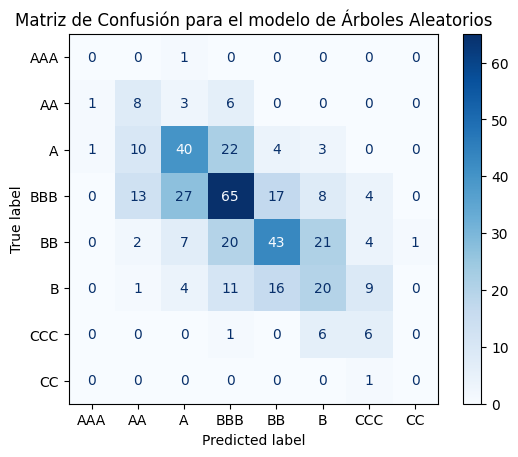

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.24      0.44      0.31        18
           A       0.49      0.50      0.49        80
         BBB       0.52      0.49      0.50       134
          BB       0.54      0.44      0.48        98
           B       0.34      0.33      0.34        61
         CCC       0.25      0.46      0.32        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.45       406
   macro avg       0.30      0.33      0.31       406
weighted avg       0.47      0.45      0.45       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 1.136063551958547
Estadístico Kappa para el modelo Árboles Aleatorios: 0.2962134637558912




13/13 [==============================] - 0s 2ms/step


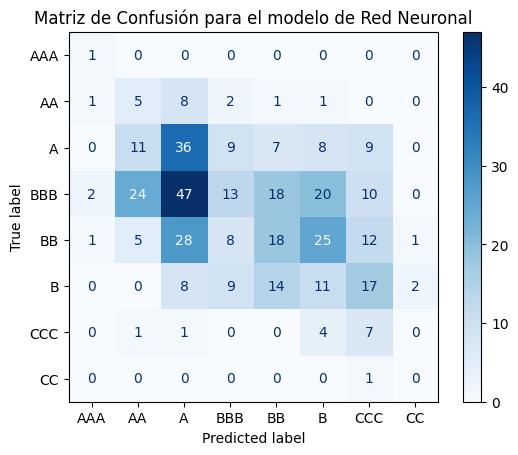

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.20      1.00      0.33         1
          AA       0.11      0.28      0.16        18
           A       0.28      0.45      0.35        80
         BBB       0.32      0.10      0.15       134
          BB       0.31      0.18      0.23        98
           B       0.16      0.18      0.17        61
         CCC       0.12      0.54      0.20        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.22       406
   macro avg       0.19      0.34      0.20       406
weighted avg       0.27      0.22      0.21       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.654222839272401
Estadístico Kappa para el modelo Red Neuronal: 0.07087071815176715


In [ ]:
experiment.run(use_smote=True, use_scaling=True, feature_selection_method='ANOVA')

##Sin Smote, sin Escalado y con la técnica Mutual Information

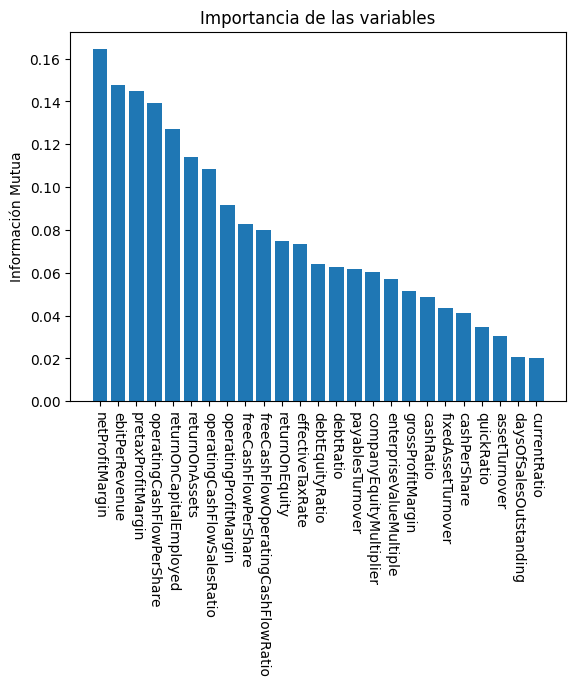

['netProfitMargin' 'pretaxProfitMargin' 'operatingProfitMargin'
 'returnOnAssets' 'returnOnCapitalEmployed' 'ebitPerRevenue'
 'operatingCashFlowPerShare' 'operatingCashFlowSalesRatio']


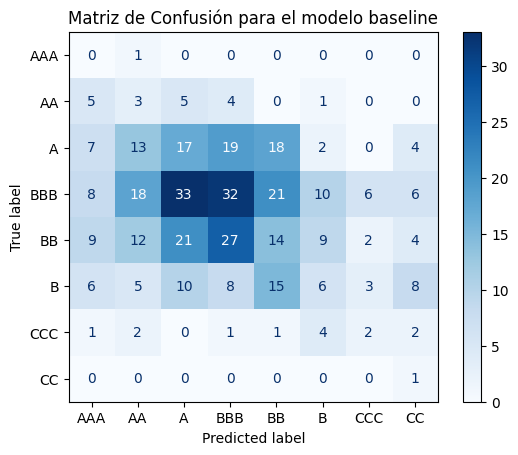

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.06      0.17      0.08        18
           A       0.20      0.21      0.20        80
         BBB       0.35      0.24      0.28       134
          BB       0.20      0.14      0.17        98
           B       0.19      0.10      0.13        61
         CCC       0.15      0.15      0.15        13
          CC       0.04      1.00      0.08         1

    accuracy                           0.18       406
   macro avg       0.15      0.25      0.14       406
weighted avg       0.24      0.18      0.20       406

Raiz del Error cuadrático medio para el modelo baseline: 1.987646577300944
Estadístico Kappa para el modelo baseline: 0.010747464040163024






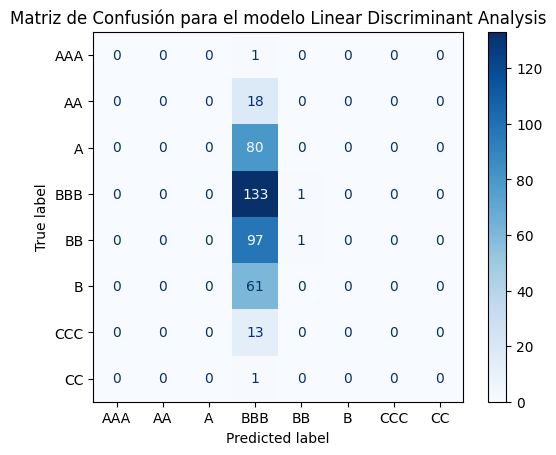

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.33      0.99      0.49       134
          BB       0.50      0.01      0.02        98
           B       0.00      0.00      0.00        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.33       406
   macro avg       0.10      0.13      0.06       406
weighted avg       0.23      0.33      0.17       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 1.2515999612712472
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.0006515601245202784




Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END ............................C=0.01;, score=0.195 total time=   0.9s
[CV 2/5] END ............................C=0.01;, score=0.188 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.293 total time=   0.6s
[CV 4/5] END ............................C=0.01;, score=0.166 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ............................C=0.01;, score=0.164 total time=   0.4s
[CV 1/5] END .............................C=0.1;, score=0.286 total time=   0.4s
[CV 2/5] END .............................C=0.1;, score=0.222 total time=   0.3s
[CV 3/5] END .............................C=0.1;, score=0.144 total time=   0.1s
[CV 4/5] END .............................C=0.1;, score=0.192 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=0.1;, score=0.158 total time=   1.2s
[CV 1/5] END ...............................C=1;, score=0.287 total time=   0.9s
[CV 2/5] END ...............................C=1;, score=0.225 total time=   0.1s
[CV 3/5] END ...............................C=1;, score=0.136 total time=   0.1s
[CV 4/5] END ...............................C=1;, score=0.203 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ...............................C=1;, score=0.137 total time=   0.6s
[CV 1/5] END ..............................C=10;, score=0.290 total time=   0.5s
[CV 2/5] END ..............................C=10;, score=0.233 total time=   0.3s
[CV 3/5] END ..............................C=10;, score=0.165 total time=   1.4s
[CV 4/5] END ..............................C=10;, score=0.197 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ..............................C=10;, score=0.148 total time=   0.5s
[CV 1/5] END .............................C=100;, score=0.289 total time=   0.4s
[CV 2/5] END .............................C=100;, score=0.235 total time=   0.2s
[CV 3/5] END .............................C=100;, score=0.200 total time=   0.4s
[CV 4/5] END .............................C=100;, score=0.225 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=100;, score=0.174 total time=   0.5s
Mejores valor de regularización para la regresión logística
{'C': 100}


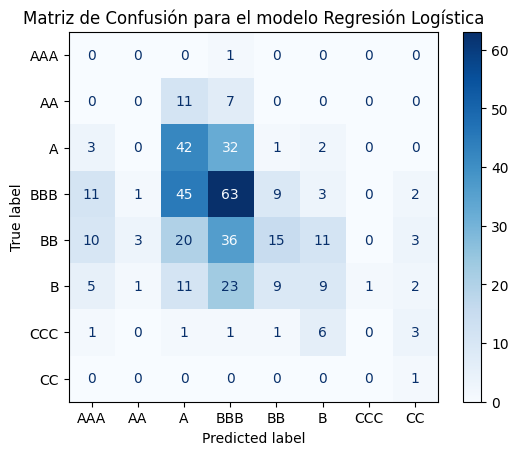

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.32      0.53      0.40        80
         BBB       0.39      0.47      0.42       134
          BB       0.43      0.15      0.23        98
           B       0.29      0.15      0.20        61
         CCC       0.00      0.00      0.00        13
          CC       0.09      1.00      0.17         1

    accuracy                           0.32       406
   macro avg       0.19      0.29      0.18       406
weighted avg       0.34      0.32      0.30       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 1.630980846658687
Estadístico Kappa para el modelo Regresión Logística: 0.11856460760330045




Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.143 total time=   0.1s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.1s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 3/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.1s
[CV 4/5] END ....C=0.01, gam

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.209 total time=   0.2s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.137 total time=   0.2s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.188 total time=   0.2s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.163 total time=   0.2s
[CV 4/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.149 total time=   0.2s
[CV 5/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.177 total time=   0.2s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.120 total time=   0.2s
[CV 2/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.126 total time=   0.2s
[CV 3/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.126 total time=   0.2s
[CV 4/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.133 total time=   0.2s
[CV 5/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.153 total time=   0.2s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.124 total time=   0.2s
[CV 2/5] END ....C=10, gamma

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.295 total time=   0.5s
[CV 1/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.172 total time=   0.5s
[CV 2/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.178 total time=   0.6s
[CV 3/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.165 total time=   0.6s
[CV 4/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.149 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.200 total time=   0.5s
[CV 1/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.132 total time=   0.2s
[CV 2/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.153 total time=   0.3s
[CV 3/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.151 total time=   0.2s
[CV 4/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.140 total time=   0.3s
[CV 5/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.166 total time=   0.2s
[CV 1/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.120 total time=   0.2s
[CV 2/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.128 total time=   0.2s
[CV 3/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.126 total time=   0.2s
[CV 4/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.128 total time=   0.2s
[CV 5/5] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.152 total time=   0.2s
Mejores hiperparámetros para el modelo SVM
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


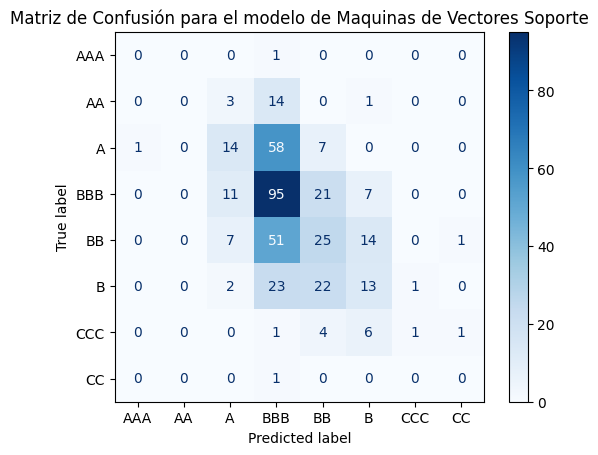

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.38      0.17      0.24        80
         BBB       0.39      0.71      0.50       134
          BB       0.32      0.26      0.28        98
           B       0.32      0.21      0.25        61
         CCC       0.50      0.08      0.13        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.36       406
   macro avg       0.24      0.18      0.18       406
weighted avg       0.34      0.36      0.32       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.1284498282060773
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.11908366131799375




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .....max_depth=8, n_estimators=200;, score=0.345 total time=   1.1s
[CV 2/5] END .....max_depth=8, n_estimators=200;, score=0.355 total time=   1.1s
[CV 3/5] END .....max_depth=8, n_estimators=200;, score=0.227 total time=   1.0s
[CV 4/5] END .....max_depth=8, n_estimators=200;, score=0.223 total time=   1.1s
[CV 5/5] END .....max_depth=8, n_estimators=200;, score=0.260 total time=   1.1s
[CV 1/5] END .....max_depth=8, n_estimators=300;, score=0.336 total time=   1.6s
[CV 2/5] END .....max_depth=8, n_estimators=300;, score=0.354 total time=   2.4s
[CV 3/5] END .....max_depth=8, n_estimators=300;, score=0.233 total time=   2.0s
[CV 4/5] END .....max_depth=8, n_estimators=300;, score=0.224 total time=   1.6s
[CV 5/5] END .....max_depth=8, n_estimators=300;, score=0.262 total time=   1.5s
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.341 total time=   2.6s
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.357 total time=   2.6s
[CV 3/5] END .....max_depth=

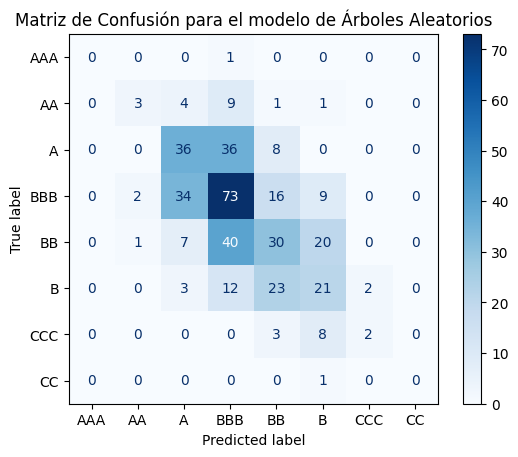

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.50      0.17      0.25        18
           A       0.43      0.45      0.44        80
         BBB       0.43      0.54      0.48       134
          BB       0.37      0.31      0.34        98
           B       0.35      0.34      0.35        61
         CCC       0.50      0.15      0.24        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.41       406
   macro avg       0.32      0.25      0.26       406
weighted avg       0.41      0.41      0.40       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 1.0609504057903922
Estadístico Kappa para el modelo Árboles Aleatorios: 0.20736528304332336




13/13 [==============================] - 0s 2ms/step


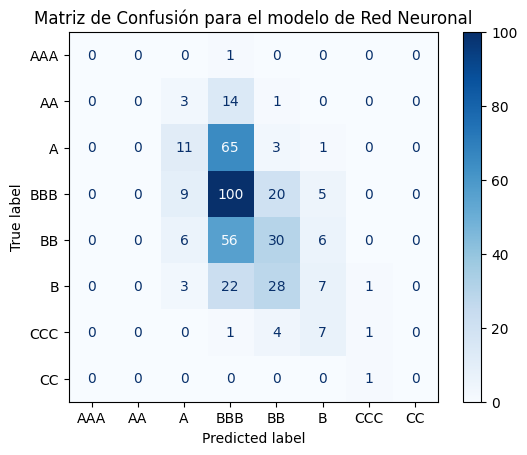

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.34      0.14      0.20        80
         BBB       0.39      0.75      0.51       134
          BB       0.35      0.31      0.33        98
           B       0.27      0.11      0.16        61
         CCC       0.33      0.08      0.12        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.37       406
   macro avg       0.21      0.17      0.16       406
weighted avg       0.33      0.37      0.31       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.081642611455492
Estadístico Kappa para el modelo Red Neuronal: 0.11211143919603106


In [ ]:
experiment.run(use_smote=False, use_scaling=False, feature_selection_method='mutual_information')

## Sin Smote, con Escalado y con la técnica de la información mutua

['netProfitMargin' 'pretaxProfitMargin' 'operatingProfitMargin'
 'returnOnAssets' 'returnOnCapitalEmployed' 'ebitPerRevenue'
 'operatingCashFlowPerShare' 'operatingCashFlowSalesRatio']


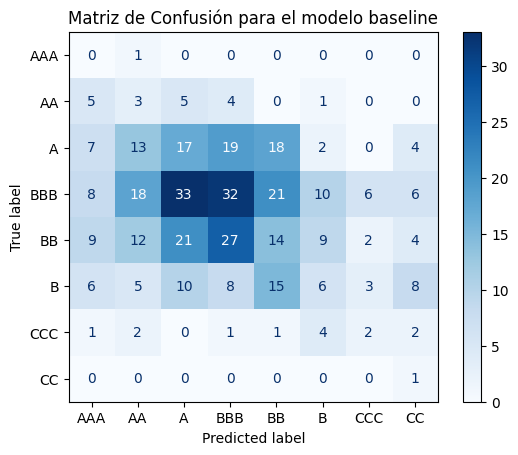

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.06      0.17      0.08        18
           A       0.20      0.21      0.20        80
         BBB       0.35      0.24      0.28       134
          BB       0.20      0.14      0.17        98
           B       0.19      0.10      0.13        61
         CCC       0.15      0.15      0.15        13
          CC       0.04      1.00      0.08         1

    accuracy                           0.18       406
   macro avg       0.15      0.25      0.14       406
weighted avg       0.24      0.18      0.20       406

Raiz del Error cuadrático medio para el modelo baseline: 1.987646577300944
Estadístico Kappa para el modelo baseline: 0.010747464040163024






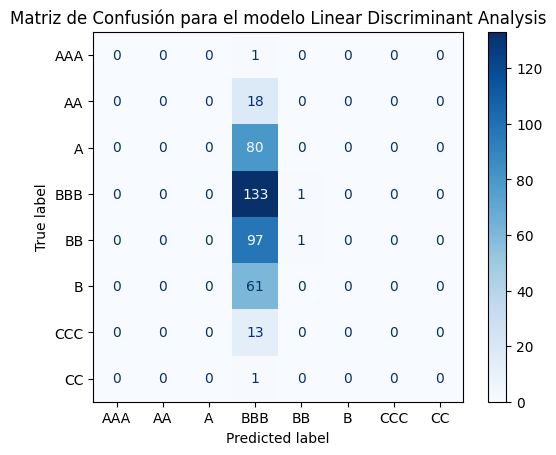

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.33      0.99      0.49       134
          BB       0.50      0.01      0.02        98
           B       0.00      0.00      0.00        61
         CCC       0.00      0.00      0.00        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.33       406
   macro avg       0.10      0.13      0.06       406
weighted avg       0.23      0.33      0.17       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 1.2515999612712472
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.0006515601245202784




Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 4/5] END ............................C=0.01;, score=0.167 total time=   0.1s
[CV 5/5] END ............................C=0.01;, score=0.204 total time=   0.1s
[CV 1/5] END .............................C=0.1;, score=0.199 total time=   0.1s
[CV 2/5] END .............................C=0.1;, score=0.147 total time=   0.1s
[CV 3/5] END .............................C=0.1;, score=0.219 total time=   0.1s
[CV 4/5] END .............................C=0.1;, score=0.167 total time=   0.1s
[CV 5/5] END .............................C=0.1;, score=0.203 total time=   0.1s
[CV 1/5] END ...............................C=1;, score=0.196 total time=   0.1s
[CV 2/5] END ...............................C=1;, score=0.255 total time=   0.2s
[CV 3/5] END ...............................C=1;, score=0.216 total time=   0.2s
[CV 4/5] END ...............................C=1;, score=0.186 total time=   0.2s
[CV 5/5] END ...............................C=1;, score=0.196 total time=   0.2s
[CV 1/5] END ...............

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END ..............................C=10;, score=0.218 total time=   0.5s
[CV 1/5] END .............................C=100;, score=0.247 total time=   0.9s
[CV 2/5] END .............................C=100;, score=0.309 total time=   0.8s
[CV 3/5] END .............................C=100;, score=0.268 total time=   1.0s
[CV 4/5] END .............................C=100;, score=0.217 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


[CV 5/5] END .............................C=100;, score=0.208 total time=   0.9s
Mejores valor de regularización para la regresión logística
{'C': 100}


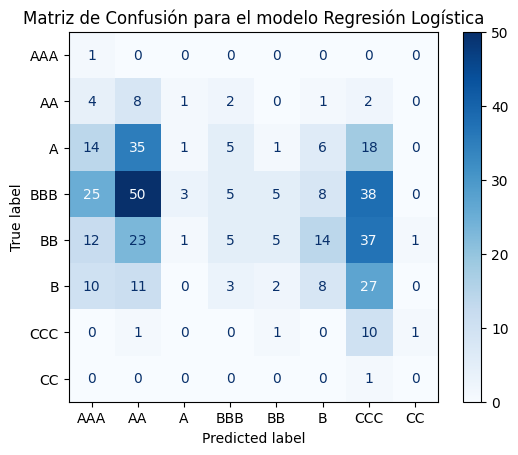

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.02      1.00      0.03         1
          AA       0.06      0.44      0.11        18
           A       0.17      0.01      0.02        80
         BBB       0.25      0.04      0.06       134
          BB       0.36      0.05      0.09        98
           B       0.22      0.13      0.16        61
         CCC       0.08      0.77      0.14        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.09       406
   macro avg       0.14      0.31      0.08       406
weighted avg       0.24      0.09      0.08       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.4338540055223206
Estadístico Kappa para el modelo Regresión Logística: 0.02947786886310777




Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.125 total time=   0.1s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 2/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.2s
[CV 5/5] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.2s
[CV 3/5] END ....C=0.01, gamma=0.01, kernel=rbf;, score=0.125 total time=   0.2s
[CV 4/5] END ....C=0.01, gam

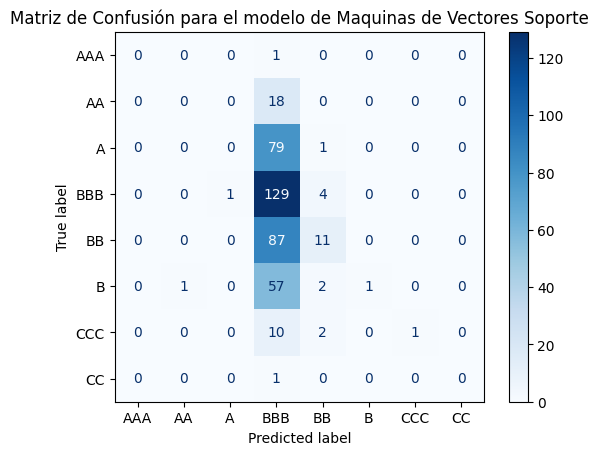

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        80
         BBB       0.34      0.96      0.50       134
          BB       0.55      0.11      0.19        98
           B       1.00      0.02      0.03        61
         CCC       1.00      0.08      0.14        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.35       406
   macro avg       0.36      0.15      0.11       406
weighted avg       0.43      0.35      0.22       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.2317635241028795
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.0388464435596686




Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/5] END .....max_depth=8, n_estimators=200;, score=0.337 total time=   1.6s
[CV 2/5] END .....max_depth=8, n_estimators=200;, score=0.362 total time=   1.7s
[CV 3/5] END .....max_depth=8, n_estimators=200;, score=0.228 total time=   1.1s
[CV 4/5] END .....max_depth=8, n_estimators=200;, score=0.225 total time=   1.0s
[CV 5/5] END .....max_depth=8, n_estimators=200;, score=0.317 total time=   1.0s
[CV 1/5] END .....max_depth=8, n_estimators=300;, score=0.331 total time=   2.4s
[CV 2/5] END .....max_depth=8, n_estimators=300;, score=0.345 total time=   2.7s
[CV 3/5] END .....max_depth=8, n_estimators=300;, score=0.219 total time=   2.3s
[CV 4/5] END .....max_depth=8, n_estimators=300;, score=0.212 total time=   1.6s
[CV 5/5] END .....max_depth=8, n_estimators=300;, score=0.314 total time=   1.6s
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.329 total time=   2.6s
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.353 total time=   2.6s
[CV 3/5] END .....max_depth=

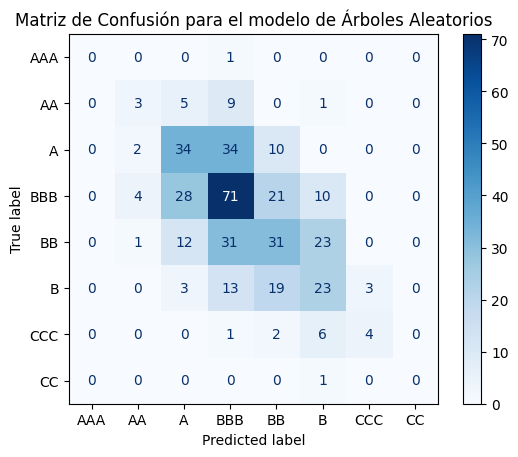

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.30      0.17      0.21        18
           A       0.41      0.42      0.42        80
         BBB       0.44      0.53      0.48       134
          BB       0.37      0.32      0.34        98
           B       0.36      0.38      0.37        61
         CCC       0.57      0.31      0.40        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.41       406
   macro avg       0.31      0.27      0.28       406
weighted avg       0.40      0.41      0.40       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 1.0940952129386956
Estadístico Kappa para el modelo Árboles Aleatorios: 0.2175190922450554




13/13 [==============================] - 0s 2ms/step


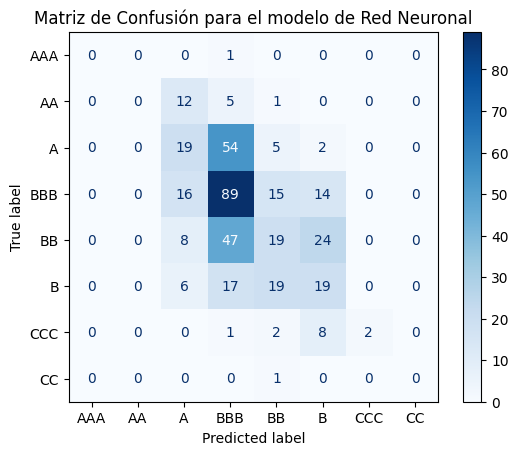

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.00      0.00      0.00        18
           A       0.31      0.24      0.27        80
         BBB       0.42      0.66      0.51       134
          BB       0.31      0.19      0.24        98
           B       0.28      0.31      0.30        61
         CCC       1.00      0.15      0.27        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.36       406
   macro avg       0.29      0.20      0.20       406
weighted avg       0.35      0.36      0.33       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.117483097369443
Estadístico Kappa para el modelo Red Neuronal: 0.13496461338992993


In [ ]:
experiment.run(use_smote=False, use_scaling=True, feature_selection_method='mutual_information')

## Con Smote, con Escalado y con la técnica Mutual Information

['netProfitMargin' 'pretaxProfitMargin' 'returnOnAssets'
 'returnOnCapitalEmployed' 'freeCashFlowOperatingCashFlowRatio'
 'ebitPerRevenue' 'operatingCashFlowPerShare'
 'operatingCashFlowSalesRatio']


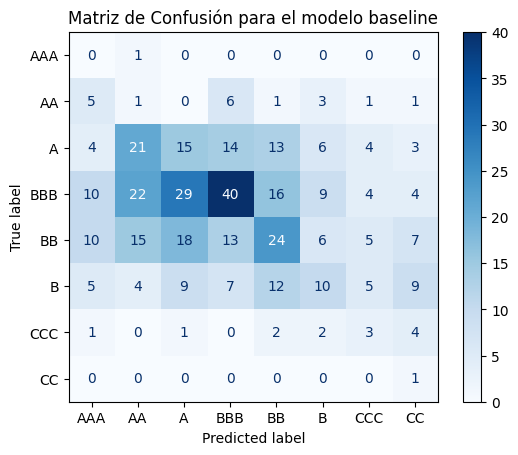

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.02      0.06      0.02        18
           A       0.21      0.19      0.20        80
         BBB       0.50      0.30      0.37       134
          BB       0.35      0.24      0.29        98
           B       0.28      0.16      0.21        61
         CCC       0.14      0.23      0.17        13
          CC       0.03      1.00      0.07         1

    accuracy                           0.23       406
   macro avg       0.19      0.27      0.17       406
weighted avg       0.34      0.23      0.27       406

Raiz del Error cuadrático medio para el modelo baseline: 2.0396319575275066
Estadístico Kappa para el modelo baseline: 0.08204704552371844






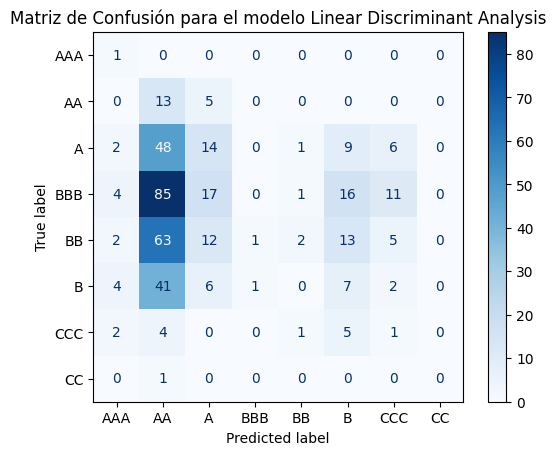

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

         AAA       0.07      1.00      0.12         1
          AA       0.05      0.72      0.10        18
           A       0.26      0.17      0.21        80
         BBB       0.00      0.00      0.00       134
          BB       0.40      0.02      0.04        98
           B       0.14      0.11      0.13        61
         CCC       0.04      0.08      0.05        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.09       406
   macro avg       0.12      0.26      0.08       406
weighted avg       0.17      0.09      0.08       406

Raiz del Error cuadrático medio para el modelo Linear Discriminant Analysis: 2.4879017610054044
Estadístico Kappa para el modelo Linear Discriminant Analysis: 0.015614911251960129




Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................

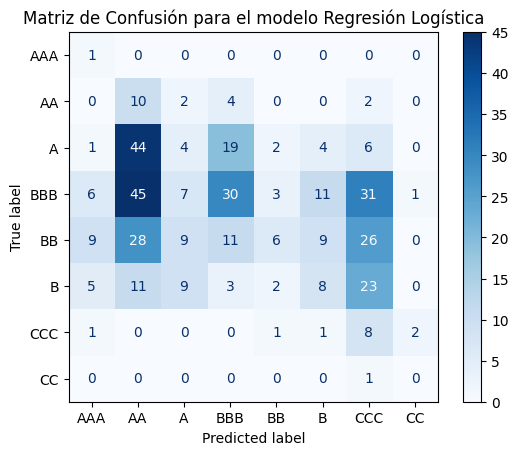

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

         AAA       0.04      1.00      0.08         1
          AA       0.07      0.56      0.13        18
           A       0.13      0.05      0.07        80
         BBB       0.45      0.22      0.30       134
          BB       0.43      0.06      0.11        98
           B       0.24      0.13      0.17        61
         CCC       0.08      0.62      0.15        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.17       406
   macro avg       0.18      0.33      0.13       406
weighted avg       0.32      0.17      0.17       406

Raiz del Error cuadrático medio para el modelo de Regresión Logística: 2.1501517875163154
Estadístico Kappa para el modelo Regresión Logística: 0.05873261205564129




Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.

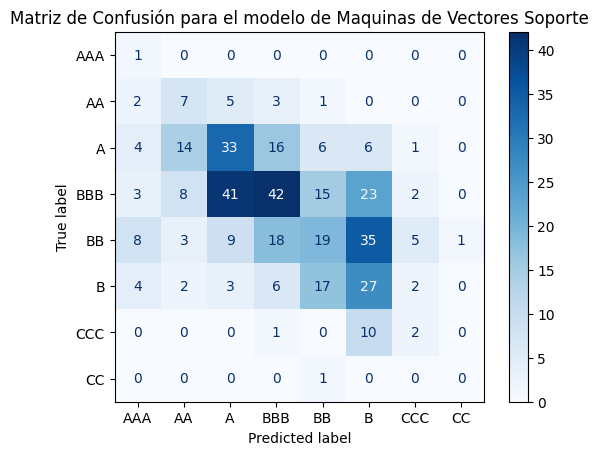

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

         AAA       0.05      1.00      0.09         1
          AA       0.21      0.39      0.27        18
           A       0.36      0.41      0.39        80
         BBB       0.49      0.31      0.38       134
          BB       0.32      0.19      0.24        98
           B       0.27      0.44      0.33        61
         CCC       0.17      0.15      0.16        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.32       406
   macro avg       0.23      0.36      0.23       406
weighted avg       0.37      0.32      0.33       406

Raiz del Error cuadrático medio para el modelo de Máquinas de Vectores Soporte: 1.4855627054164149
Estadístico Kappa para el modelo Maquinas de Vectores Soporte: 0.1624030368047532




Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .....max_depth=8,

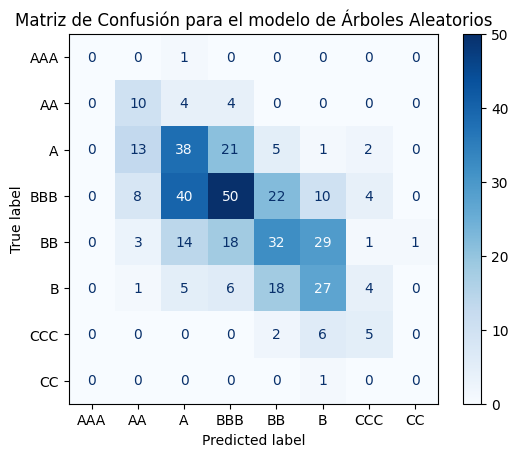

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

         AAA       0.00      0.00      0.00         1
          AA       0.29      0.56      0.38        18
           A       0.37      0.47      0.42        80
         BBB       0.51      0.37      0.43       134
          BB       0.41      0.33      0.36        98
           B       0.36      0.44      0.40        61
         CCC       0.31      0.38      0.34        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.40       406
   macro avg       0.28      0.32      0.29       406
weighted avg       0.42      0.40      0.40       406

Raiz del Error cuadrático medio para el modelo de Árboles Aleatorios: 1.171290391946425
Estadístico Kappa para el modelo Árboles Aleatorios: 0.23981122664313392




13/13 [==============================] - 0s 2ms/step


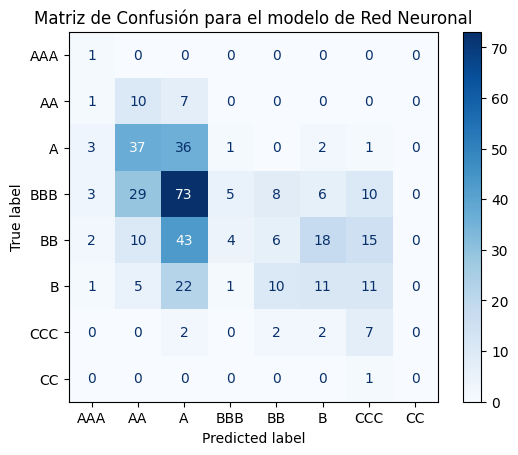

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

         AAA       0.09      1.00      0.17         1
          AA       0.11      0.56      0.18        18
           A       0.20      0.45      0.27        80
         BBB       0.45      0.04      0.07       134
          BB       0.23      0.06      0.10        98
           B       0.28      0.18      0.22        61
         CCC       0.16      0.54      0.24        13
          CC       0.00      0.00      0.00         1

    accuracy                           0.19       406
   macro avg       0.19      0.35      0.16       406
weighted avg       0.30      0.19      0.15       406

Raiz del Error cuadrático medio para el modelo Red Neuronal: 1.7026493409757404
Estadístico Kappa para el modelo Red Neuronal: 0.053552885328586264


In [ ]:
experiment.run(use_smote=True, use_scaling=True, feature_selection_method='mutual_information')